# Deep Learning Assignment 2023 - Visual Grounding

**Manuel Avesani, 233401**

**Mattia Nardon, 233707**

**Gabriele Santini, 239268**


## INTRODUCTION

This assignment centers around the concept of **visual grounding**, which entails connecting language and perception by establishing a link between linguistic symbols and the visual aspects of the world.
In particular, the model has to return a bounding box within an image that represents the entities mentioned in the description of the image.

We propose as solution for the assignment four models:

1.   Baseline

> The first proposal is the baseline, which is the union of **YOLO** (You Only Look Once) and **CLIP**.



2.   Baseline + NLP classifier

> The second approach utilizes an **NLP** (Natural Language Processing) classifier to determine the class of the subject mentioned in the captions.

3.   YOLO + BLIP

> In the third proposal, we leverage the **text localization** capabilities of **BLIP** (Bootstrapping Language-Image Pre-training). **BLIP** allows us to localize a specific caption within an image by identifying its spatial region. To determine the bounding box, we select the one generated by **YOLO** that intersects the most with the localization provided by **BLIP**.

4.   DETR + CLIP

> For the last approach, we made a modification to the baseline model by replacing **YOLO** with **DETR** (End-to-End Object Detection with Transformers).



## ENVIRONMENT SETUP

This part is for the creation of the environment.
In order to run this notebook, we need to create the environment by installing the required dependencies and setting up the directories. First, we download the dataset from the provided link using the `gdown` library. Then, we extract the downloaded dataset using the `tar` command. Alternatively, we can load the dataset from a personal Google Drive by mounting the drive and extracting the dataset. Once the dataset is loaded, we define the directory paths for the dataset.


### Dataset from Link

In [ ]:
### Dataset from Link

import gdown
gdown.download('https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq', '/content/refcocog.tar.gz', quiet=False)
!tar -xf  /content/refcocog.tar.gz
# # It takes ~4 min

Downloading...
From: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
To: /content/refcocog.tar.gz
100%|██████████| 13.5G/13.5G [01:12<00:00, 186MB/s]


#### Data Loading from Personal Drive

In [ ]:
#### Data Loading from Personal Drive
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/gdrive')
# !tar -xf /content/gdrive/MyDrive/DEEP_LEARNING_PROJECT/refcocog.tar.gz

### Directories

In [ ]:
# DIRECTORIES
ROOT_PATH = '/content'
ANNS_PATH = f'{ROOT_PATH}/refcocog/annotations'
DATA_PATH = f'{ROOT_PATH}/refcocog/images'

### Installing Required Modules
Next, we install the required modules for our project. This includes:
* CLIP (OpenAI's Contrastive Language-Image Pretraining)
* YOLO (Ultralytics' Object Detection)
* transformers (Hugging Face's Transformers)
* salesforce-lavis (Salesforce's BLIP)

In [ ]:
# INSTALL REQUIRED MODULE

# ! pip install git+https://github.com/openai/CLIP.git #CLIP
# ! pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  #YOLO
!pip install transformers #BERT, DETR
# !pip install salesforce-lavis #BLIP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.6 MB/s eta 0:00:00


### Imports

After installing the dependencies, we import the necessary libraries and modules for our project. These include modules for image processing, data manipulation, visualization, deep learning frameworks, and other utilities.


In [ ]:
# IMPORTS
import os
import pickle
import json
import gdown

from PIL import Image, ImageDraw, ImageFont

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import clip

import torchvision.transforms as T
import torch.nn.functional as F

In [ ]:
from IPython.display import clear_output

## DATASET

The Dataset class from torch.utils.data is a PyTorch utility class used for creating custom datasets. It provides an interface to load and preprocess data for training or evaluation in a structured and efficient manner.


In [ ]:
from torch.utils.data import Dataset, Subset

def format_filename(s):
    a = s.split('_')
    return f'{a[0]}_{a[1]}_{a[2]}.jpg'

def parseCoord(coord):
    return [int(coord[0]), int(coord[1]), int(coord[0] + coord[2]), int(coord[1] + coord[3])]

class LoadedDataset(Dataset):
    def __init__(self):

        # Open PICKLE file
        with open(f'{ANNS_PATH}/refs(umd).p', 'rb') as f:
            refs = pd.DataFrame.from_dict(pickle.load(f, fix_imports=True, encoding='ASCII', errors='strict', buffers=None))

        # Open JSON file
        with open(f'{ANNS_PATH}/instances.json', 'r') as json_file:
            anns = pd.DataFrame.from_dict(json.load(json_file)['annotations'])
            anns.drop(columns=['category_id', 'image_id'], inplace=True)

        # Merge the two Dataframes
        self._dataframe = pd.merge(refs, anns, left_on='ann_id', right_on='id')
        self._dataframe.drop(columns=['ann_id'], inplace=True)
        self._dataframe = self._dataframe.explode(['sentences', 'sent_ids'])
        self._dataframe = self._dataframe.reset_index()
        self._dataframe.drop(columns=['index'], inplace=True)

        # Correct the image filename
        self._dataframe['file_name'] = self._dataframe['file_name'].apply(format_filename)

        # Le bounding box nel dataset sono in formato [x0, y0, w, h] le trasformo in [x0, y0, x1, y1]
        self._dataframe['bbox'] = self._dataframe['bbox'].apply(parseCoord)


    def __len__(self):
        return len(self._dataframe)

    def get_trainset_idx(self):
        train_idxs = self._dataframe[self._dataframe['split'] == 'train'].index
        print(f'Trainset len: {len(train_idxs)}')
        return train_idxs

    def get_valset_idx(self):
        val_idxs = self._dataframe[self._dataframe['split'] == 'val'].index
        print(f'Valset len: {len(val_idxs)}')
        return val_idxs

    def get_testset_idx(self):
        test_idxs = self._dataframe[self._dataframe['split'] == 'test'].index
        print(f'Testset len: {len(test_idxs)}')
        return test_idxs

    def __getitem__(self, idx):
        filename = self._dataframe.iloc[idx]['file_name']
        image = Image.open(f'{ROOT_PATH}/refcocog/images/{filename}').convert('RGB')

        target = self._dataframe.iloc[idx]['bbox'] #il target è la bounding box ground truth

        input = [image, self._dataframe.iloc[idx]['sentences']['raw']] # l'input è una lista image e label

        return idx, input, target

In [ ]:
# Create Dataset
dataset = LoadedDataset()

#ONLY FOR QUICK TESTING -> crop the dataframe
# dataset._dataframe = dataset._dataframe.sample(n=10000, replace=False)
# dataset._dataframe = dataset._dataframe.reset_index()
# dataset._dataframe.drop(columns=['index'], inplace=True)

In [ ]:
from torch.utils.data import DataLoader

# Define a custom collate fuction (needed to create batch)
def my_collate(batch):
    id = [item[0] for item in batch]
    data = [item[1] for item in batch]
    target = [item[2] for item in batch]
    return [id, data, target]

# Initialize dataloaders
def get_data(split, batch_size, num_workers=1):
    match split:
        case 'train':
            return DataLoader(Subset(dataset, dataset.get_trainset_idx()), num_workers=num_workers, batch_size=batch_size, collate_fn=my_collate, shuffle=False, drop_last=True)
        case 'val':
            return DataLoader(Subset(dataset, dataset.get_valset_idx()), num_workers=num_workers, batch_size=batch_size, collate_fn=my_collate, shuffle=False, drop_last=True)
        case 'test':
            return DataLoader(Subset(dataset, dataset.get_testset_idx()), num_workers=num_workers, batch_size=batch_size, collate_fn=my_collate, shuffle=False, drop_last=True)
        case _:
            return None

## UTILITIES

This section contains utility functions that improve code readability and maintainability.


In [ ]:
# Get predicted patches by cropping the image using the bboxes coordinates

def cropImage(image, boxes):
  cropped_images = [] # list of the cropped images using the bb
  coordinates = [] # list of the coordinates of the bb
  transform = T.ToTensor()
  image = transform(image)
  image = image.unsqueeze(0)

  for i, bb in enumerate(boxes):

      # fix negative coordinates by max(n,0) instead of the ifs
      x_min = max(int(bb[0]),0)
      y_min = max(int(bb[1]),0)
      x_max = max(int(bb[2]),0)
      y_max = max(int(bb[3]),0)

      # check that the area is not zero
      if (abs(x_min-x_max) * abs(y_min-y_max)) != 0:
        cropped_image = image[:, :, y_min:y_max, x_min:x_max]
        cropped_images.append(cropped_image)
        coordinates.append([x_min, y_min, x_max, y_max])

  return cropped_images, coordinates

In [ ]:
# Given the text label and the patches return the patch (and its coordinates) with the maximum similarity
def performCLIP(self, device, text, cropped_images, coordinates):

    # Tokenize, Encode and then normalize the text label
    text_tokens = clip.tokenize(text).to(device)
    with torch.no_grad():
        text_features = self.clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    index = 0
    max_sim = 0
    for i, img in enumerate(cropped_images):

        img = img.to(device)
        img = self.transformClip(img)

        with torch.no_grad():
            image_features = self.clip_model.encode_image(img).float()

        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

        if similarity > max_sim:
            max_sim = similarity
            index = i

    best_bounding_box = cropped_images[index]
    best_coordinate = coordinates[index]

    return best_bounding_box, best_coordinate

In [ ]:
import torchvision.ops as ops

def getUniqueBoxes(boxes, scores,  threshold= 0.99):
    selected_indices = ops.nms(torch.stack(boxes), scores, threshold)
    unique_boxes = [boxes[i] for i in selected_indices]

    return unique_boxes

In [ ]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x, device):
    x_c, y_c, w, h = x
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.tensor(b).to(device)

def rescale_bboxes(out_bbox, size, device):
    img_w, img_h = size
    bbs = []
    for bb in out_bbox:

      b = box_cxcywh_to_xyxy(bb,device)

      b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)

      bbs.append(b)
    return bbs

## MODELS


### 1. BASELINE


#### Model definition
The baseline model serves as the foundation for our project, providing a benchmark score for the task and serving as a building block for the approaches we implemented.
We implemented our model as suggested in the assignment paper.
The model pipeline operates as follows:

1. The YOLO model is employed to detect all possible objects present in the image.
2. The proposed bounding boxes generated by YOLO are then passed to the CLIP model.
3. The CLIP model calculates similarity scores between the cropped image obtained from each bounding box and the corresponding text label.
4. The cropped image, along with the associated coordinates of the bounding box, having the highest similarity score is selected as the output of the model.

By combining the capabilities of YOLO for object detection and CLIP for measuring similarity between images and text, our model aims to identify the most relevant object based on the text label.


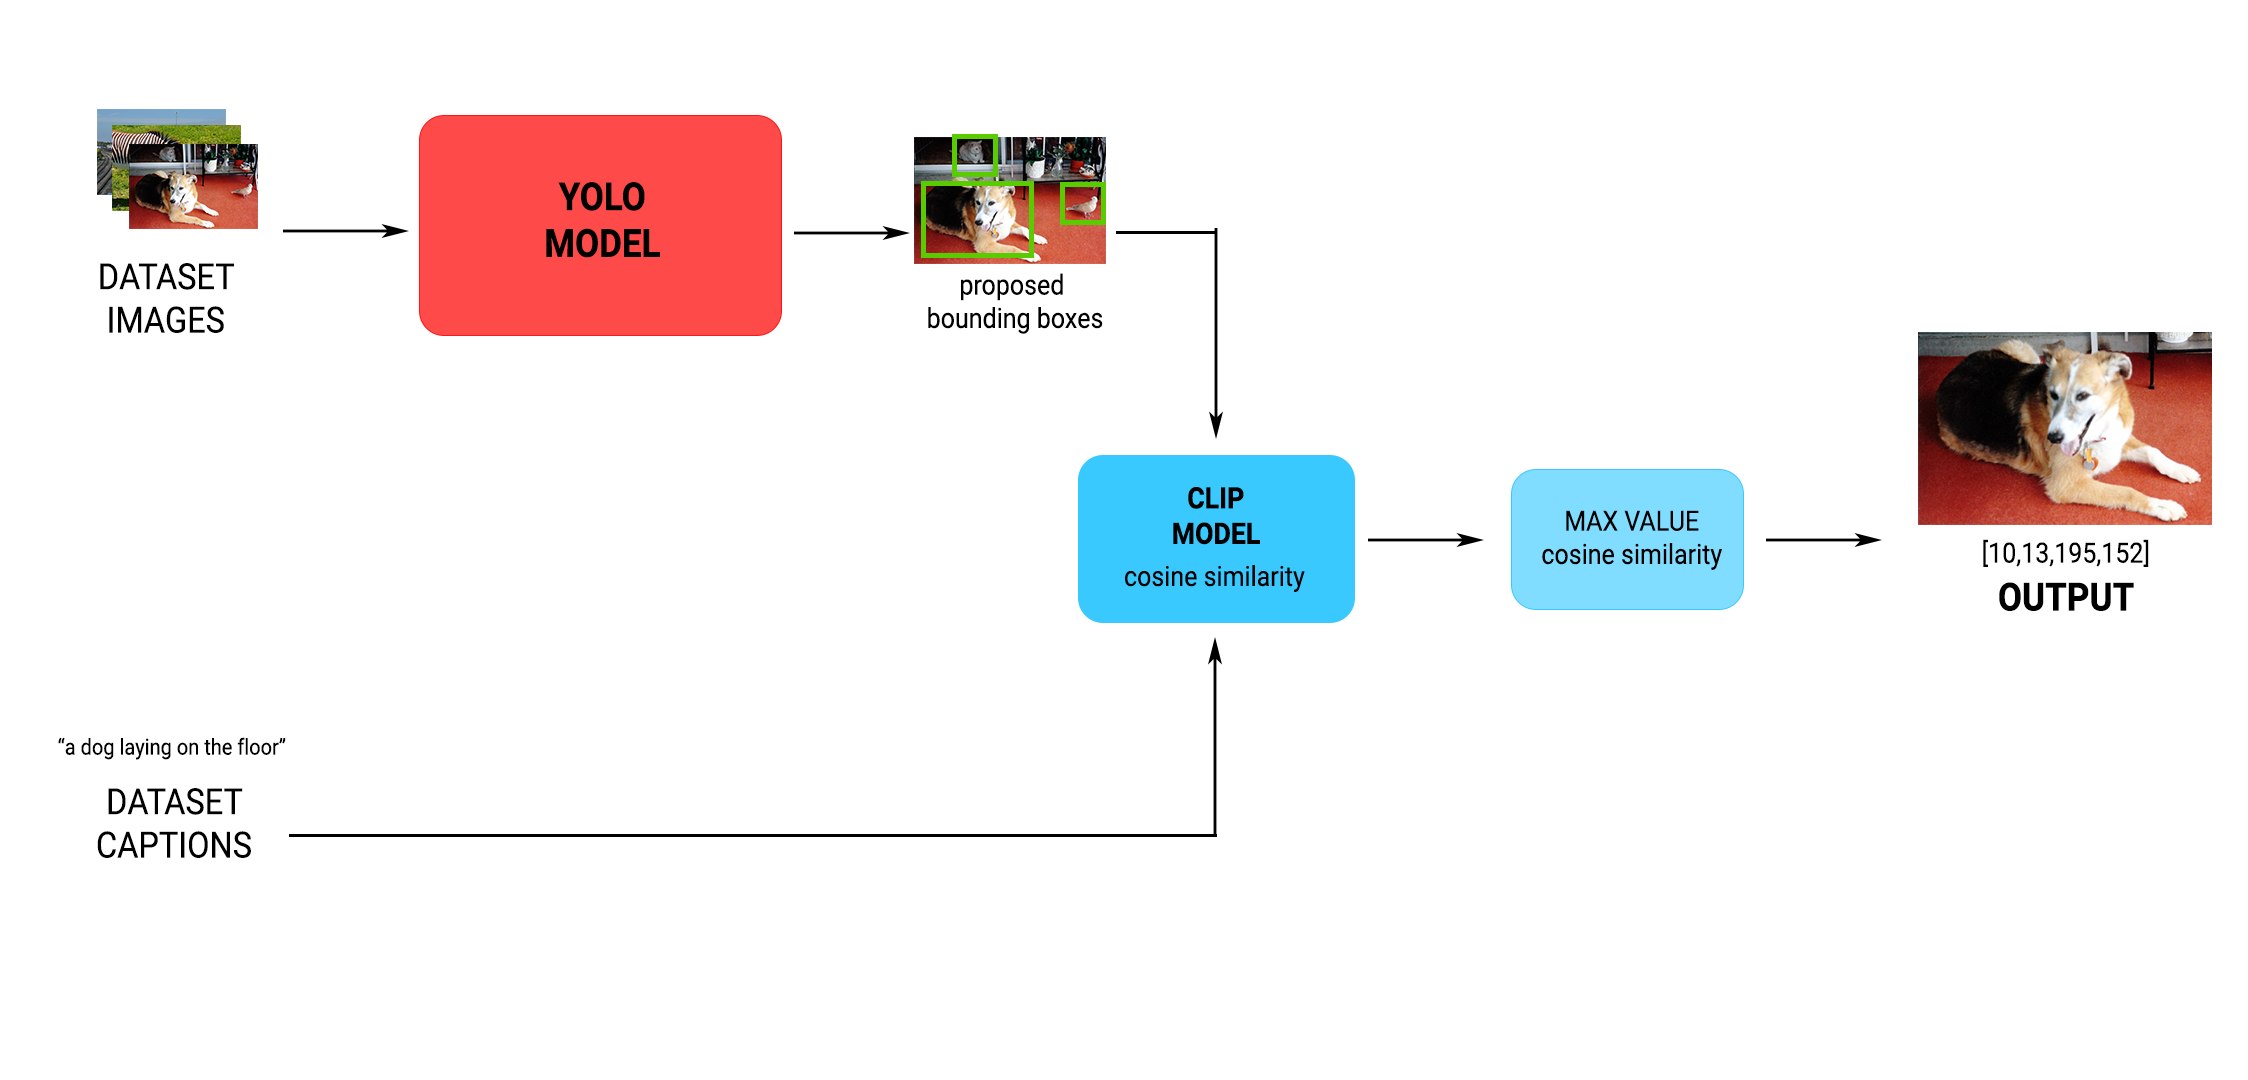

#### BASELINE code

In [ ]:
class YOLOClipModel(torch.nn.Module):
    def __init__(self, device,  yolo_model, clip_model, yoloParams, clipPreprocessing):
        super().__init__()
        self.device = device

        # Load Yolo and Clip
        self.yolo_model = yolo_model
        self.clip_model = clip_model

        # YOLO params
        self.yolo_model.conf = yoloParams['conf'] # NMS confidence threshold
        self.yolo_model.iou = yoloParams['iou']  # NMS IoU threshold
        self.yolo_model.max_det = yoloParams['max_det']  # maximum number of detections per image

        # Define CLIP transformations
        self.transformClip = clipPreprocessing


    def forward(self, data):
        image, text = [input for input in data]

        results = self.yolo_model(image)

        if len(results.pandas().xyxy[0]) ==0 :
          temp = self.yolo_model.conf
          self.yolo_model.conf = 0
          results = self.yolo_model(image)
          self.yolo_model.conf = temp

        # Extract patches predicted by YOLO
        columns_to_extract = ['xmin', 'ymin', 'xmax', 'ymax']
        df = results.pandas().xyxy[0]
        boxes = df[columns_to_extract].values.tolist()
        cropped_images, coordinates = cropImage(image, boxes)

        return performCLIP(self, self.device, text, cropped_images, coordinates)

    def get_imageEncoded(self, image):
        img = self.transformClip(image).to(self.device)
        return self.clip_model.encode_image(img).to(self.device)

### 2. BASELINE + NLP classifier


#### Model definition

The second approach builds upon the baseline model by incorporating an NLP classifier to determine the class of the subject mentioned in the captions.

The model pipeline operates as follows:

1. The NLP classifier takes the caption as input and identifies the class of the subject mentioned.
2. The YOLO model is utilized to detect all possible bounding boxes in the image that correspond to the class obtained from the NLP classifier.
3. The proposed bounding boxes generated by YOLO are then passed to the CLIP model.
4. The CLIP model calculates similarity scores between the cropped image obtained from each bounding box and the corresponding text label.
5. The cropped image, along with the associated coordinates of the bounding box, having the highest similarity score is selected as the output of the model.


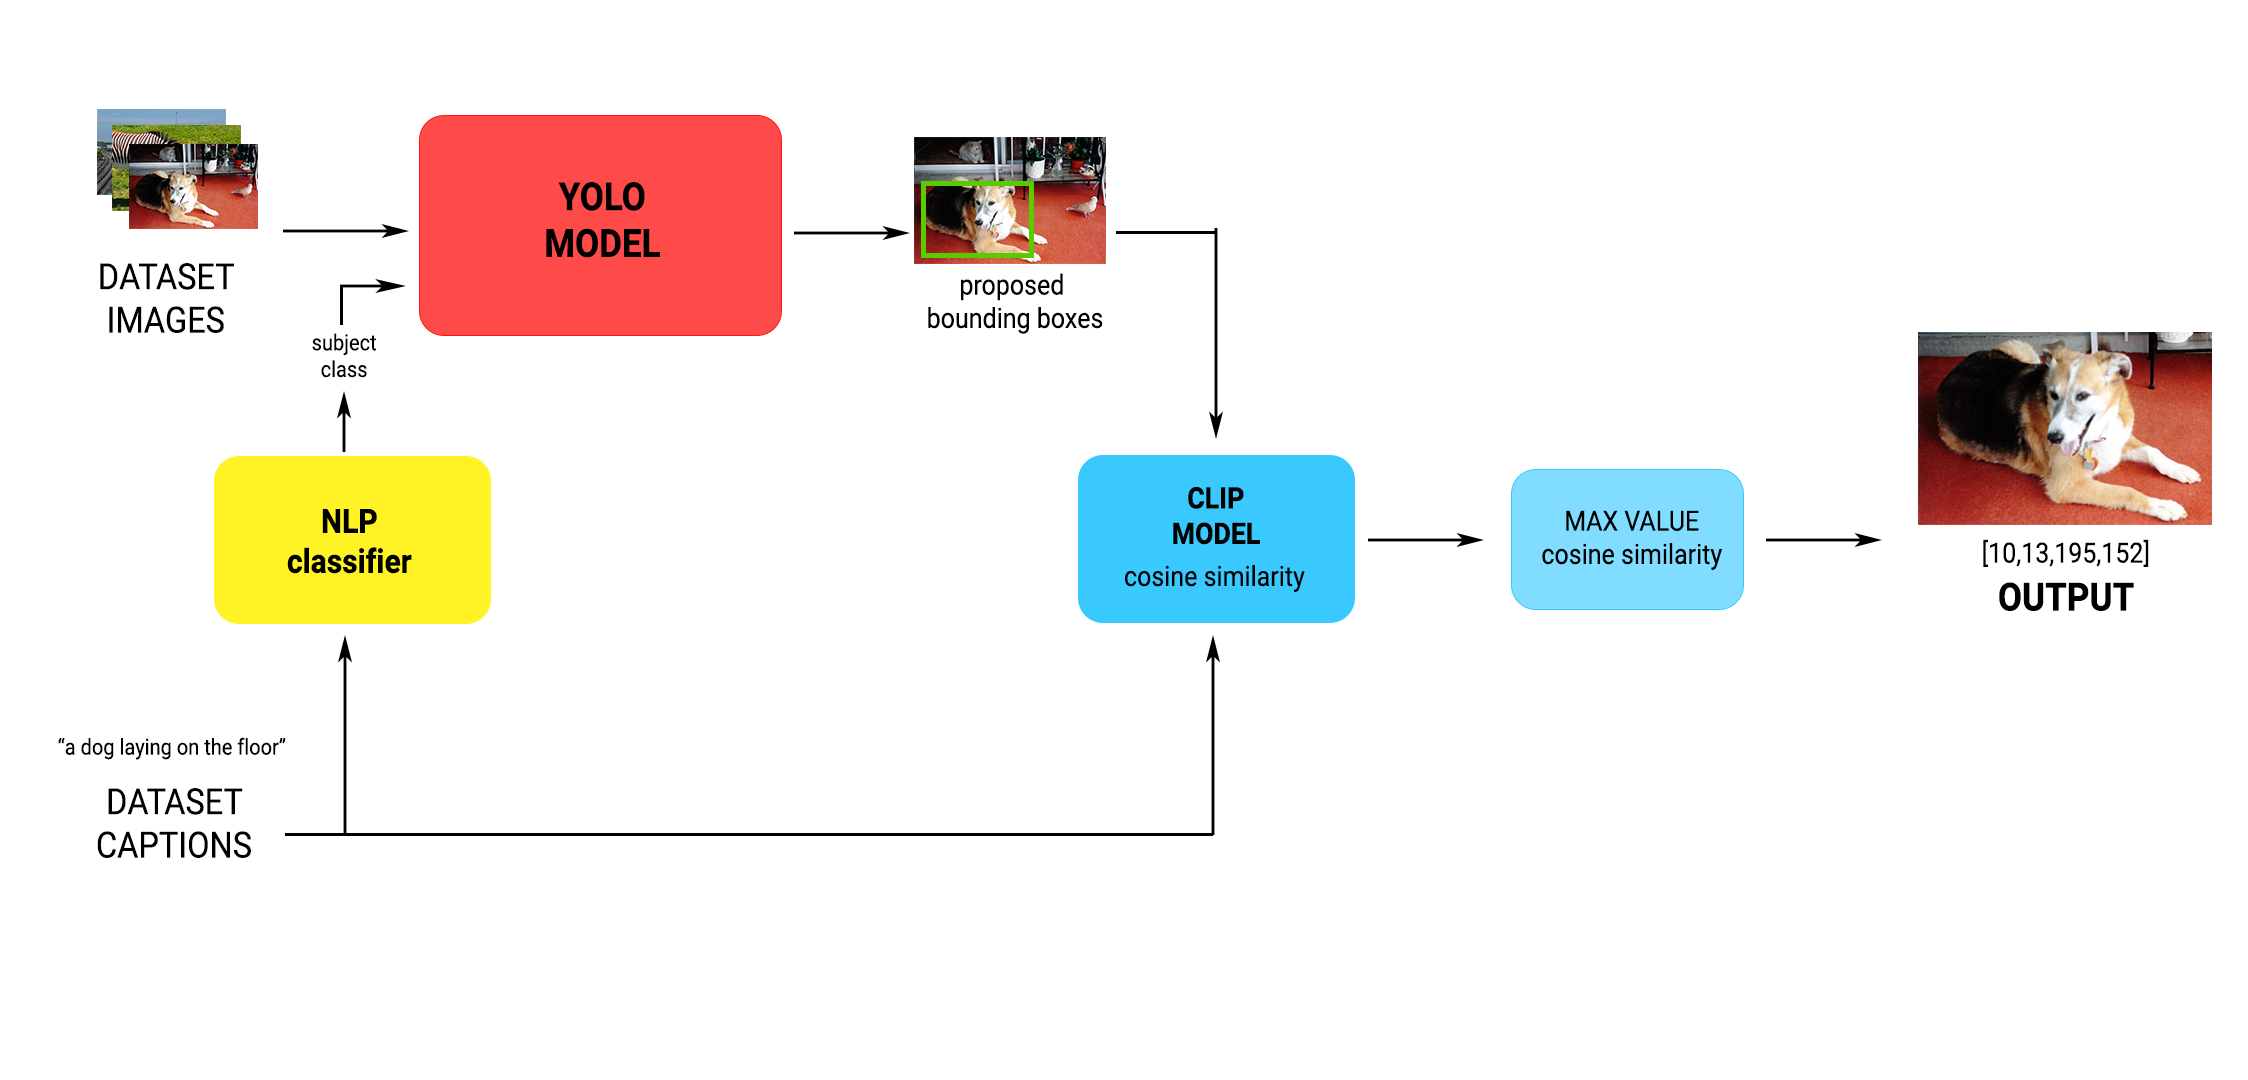

#### NLP classifier

For the NLP classifier, we utilize the pretrained BERT encoder. This encoder is pre-trained on a large corpus of text data and is known for its ability to capture rich contextual representations. To adapt the BERT encoder's output to our specific task, we add a linear layer on top of it. This linear layer reduces the output dimension from 768 to 91, which corresponds to the number of classes present in both YOLO and RefCOCOg datasets.

By incorporating the pretrained BERT encoder and the additional linear layer, our NLP classifier can effectively process the input caption and predict the class of the subject mentioned.


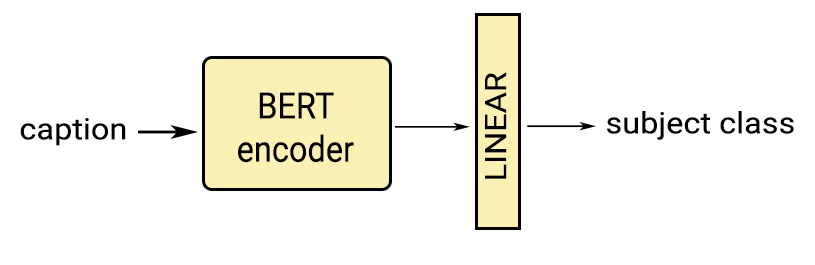

The encoder part of BERT processes input text using self-attention and feed-forward neural networks. Self-attention captures word dependencies, while the feed-forward network applies transformations. Layer normalization and residual connections enhance training stability and information flow. Stacking these layers enables BERT to generate contextualized representations for words, facilitating various language processing tasks.

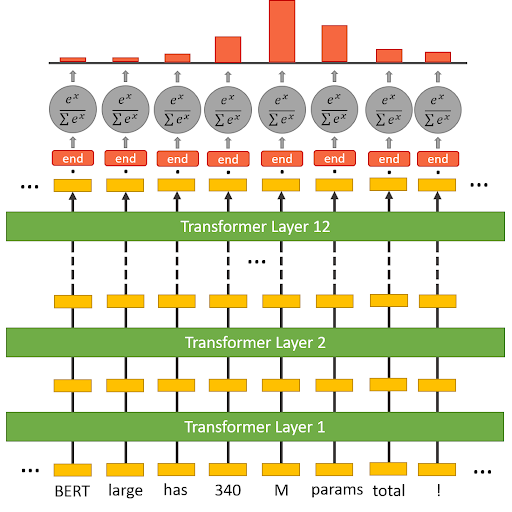

This is the composition of a transformer encoder

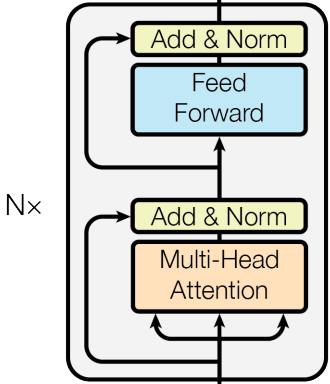

##### TRAINING classifier
We trained the linear layer for classification using the params recommended in BERT paper (Paragraph A.3):
* optimizer = torch.optim.AdamW
* learning rate = 5e-5
* epochs = 2
* batch size = 16

And achieved  this performance:
* Train loss: 0.2263
* Validation Accuracy: 0.9275


#### BASELINE + NLP classifier code

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import yaml

# Define a new model that combines YOLO and CLIP
class BERT_YOLO(torch.nn.Module):
    def __init__(self, device,  yolo_model, yoloParams):
        super().__init__()
        self.device = device

        # Load the BertForSequenceClassification model
        self.bert_model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels = 91,
            output_attentions = False,
            output_hidden_states = False,
        )

        # Load finetuned weights
        !mkdir '/content/BERT'
        gdown.download('https://drive.google.com/uc?id=104wBJrj67SIZAz89GWoTsKMu-y8fq9tQ&export=download', '/content/BERT/model.pth', quiet=False)
        if torch.cuda.is_available():
            self.bert_model.load_state_dict(torch.load('/content/BERT/model.pth'))
            self.bert_model.cuda()
        else:
            self.bert_model.load_state_dict(torch.load('/content/BERT/model.pth', map_location=torch.device('cpu')))

        # Load Bert Tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(
        'bert-base-uncased',
        do_lower_case = True
        )

        # Load Baseline
        self.yolo_model = yolo_model

        # YOLO params
        self.yolo_model.conf = yoloParams['conf'] # NMS confidence threshold
        self.yolo_model.iou = yoloParams['iou']  # NMS IoU threshold
        self.yolo_model.max_det = yoloParams['max_det']  # maximum number of detections per image


        # TRANSLATE FROM COCO CLASS NUMBER TO YOLO CLASS NUMBER
        # Open the YAML file of YOLO classes
        with open('/root/.cache/torch/hub/ultralytics_yolov5_master/data/coco128.yaml', 'r') as file:
            # Load the YAML content
            yaml_content = yaml.safe_load(file)
            self.yolodict = yaml_content['names']
            self.yolodict = {value: key for key, value in self.yolodict.items()}

        # Get CoCo classes
        with open(f'{ANNS_PATH}/instances.json', 'r') as json_file:
            anns = json.load(json_file)['categories']
            self.cocodict = {}
            for dictionary in anns:
                key = dictionary['id']
                value = dictionary['name']
                self.cocodict[key] = value

    def translateCocoYolo(self, cocoNum):
        return self.yolodict[self.cocodict[cocoNum]]

    def forward(self, data):
        image, text = [input for input in data]

        # We need Token IDs and Attention Mask for inference on the new sentence
        test_ids = []
        test_attention_mask = []

        # Apply the tokenizer
        encoding = self.tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = 32,
                        padding = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

        # Extract IDs and Attention Mask
        test_ids.append(encoding['input_ids'])
        test_attention_mask.append(encoding['attention_mask'])
        test_ids = torch.cat(test_ids, dim = 0)
        test_attention_mask = torch.cat(test_attention_mask, dim = 0)

        # Forward pass, calculate logit predictions
        with torch.no_grad():
            output = self.bert_model(test_ids.to(self.device), token_type_ids = None, attention_mask = test_attention_mask.to(self.device))

        # Restrict Yolo to the class predicted by Bert
        predictClass = np.argmax(output.logits.cpu().numpy()).flatten().item()
        predictClass = self.translateCocoYolo(predictClass)
        self.yolo_model.classes = [predictClass]
        results = self.yolo_model(image)

        # If no Bboxes found search with no classes
        if len(results.pandas().xyxy[0]) == 0:
            temp = self.yolo_model.conf
            self.yolo_model.conf = 0
            self.yolo_model.classes = None
            results = self.yolo_model(image)
            self.yolo_model.conf = temp

        return results



In [ ]:
class BERT_BaseModel(torch.nn.Module):
    def __init__(self, device,  yolo_model, clip_model, yoloParams, clipPreprocessing):
        super().__init__()
        self.device = device
        self.nlpYolo = BERT_YOLO(device, yolo_model, yoloParams)

        self.clip_model = clip_model
        self.transformClip = clipPreprocessing


    def forward(self, data):
        image, text = [input for input in data]

        results = self.nlpYolo(data)

        # Extract patches predicted by YOLO
        columns_to_extract = ['xmin', 'ymin', 'xmax', 'ymax']
        df = results.pandas().xyxy[0]
        boxes = df[columns_to_extract].values.tolist()
        cropped_images, coordinates = cropImage(image, boxes)
        print(len(cropped_images))
        # for im in cropped_images:
        #     trans = transforms.ToPILImage()
        #     imagine = trans(im)
        #     imagine.show
        return performCLIP(self, self.device, text, cropped_images, coordinates)

    def get_imageEncoded(self, image):
        img = self.transformClip(image).to(self.device)
        return self.clip_model.encode_image(img).to(self.device)

### 3. YOLO + BLIP


#### Model definition
In the third proposal, we incorporate the text localization capabilities of BLIP, which is a foundation model for language and vision. While BLIP draws inspiration from CLIP, it has a slightly different training objective and offers unique capabilities.

With BLIP, we can localize a specific caption within an image by computing gradcams. Gradcams (Gradient-weighted Class Activation Maps) are visualizations that highlight the spatial regions in an image that are most important for a specific class or caption.
By calculating gradcams, we can identify the spatial region in the image that corresponds to the mentioned caption, providing valuable insights into the location of the subject within the image.

To determine the bounding box, we select the one generated by YOLO that intersects the most with the localization provided by BLIP. By combining the strengths of YOLO's object detection and BLIP's text localization, we aim to improve the accuracy of localizing relevant objects based on the given captions.

The model pipeline operates as follows:

1. BLIP is utilized to localize the spatial region in the image that corresponds to the caption by calculating the gradcams.
2. The YOLO model is employed to detect all possible objects present in the image.
3. The proposed bounding boxes generated by YOLO are then intersected with the gradcam of the BLIP model.
4. The cropped image, along with the associated coordinates of the bounding box, having the highest score, is selected as the output of the model.


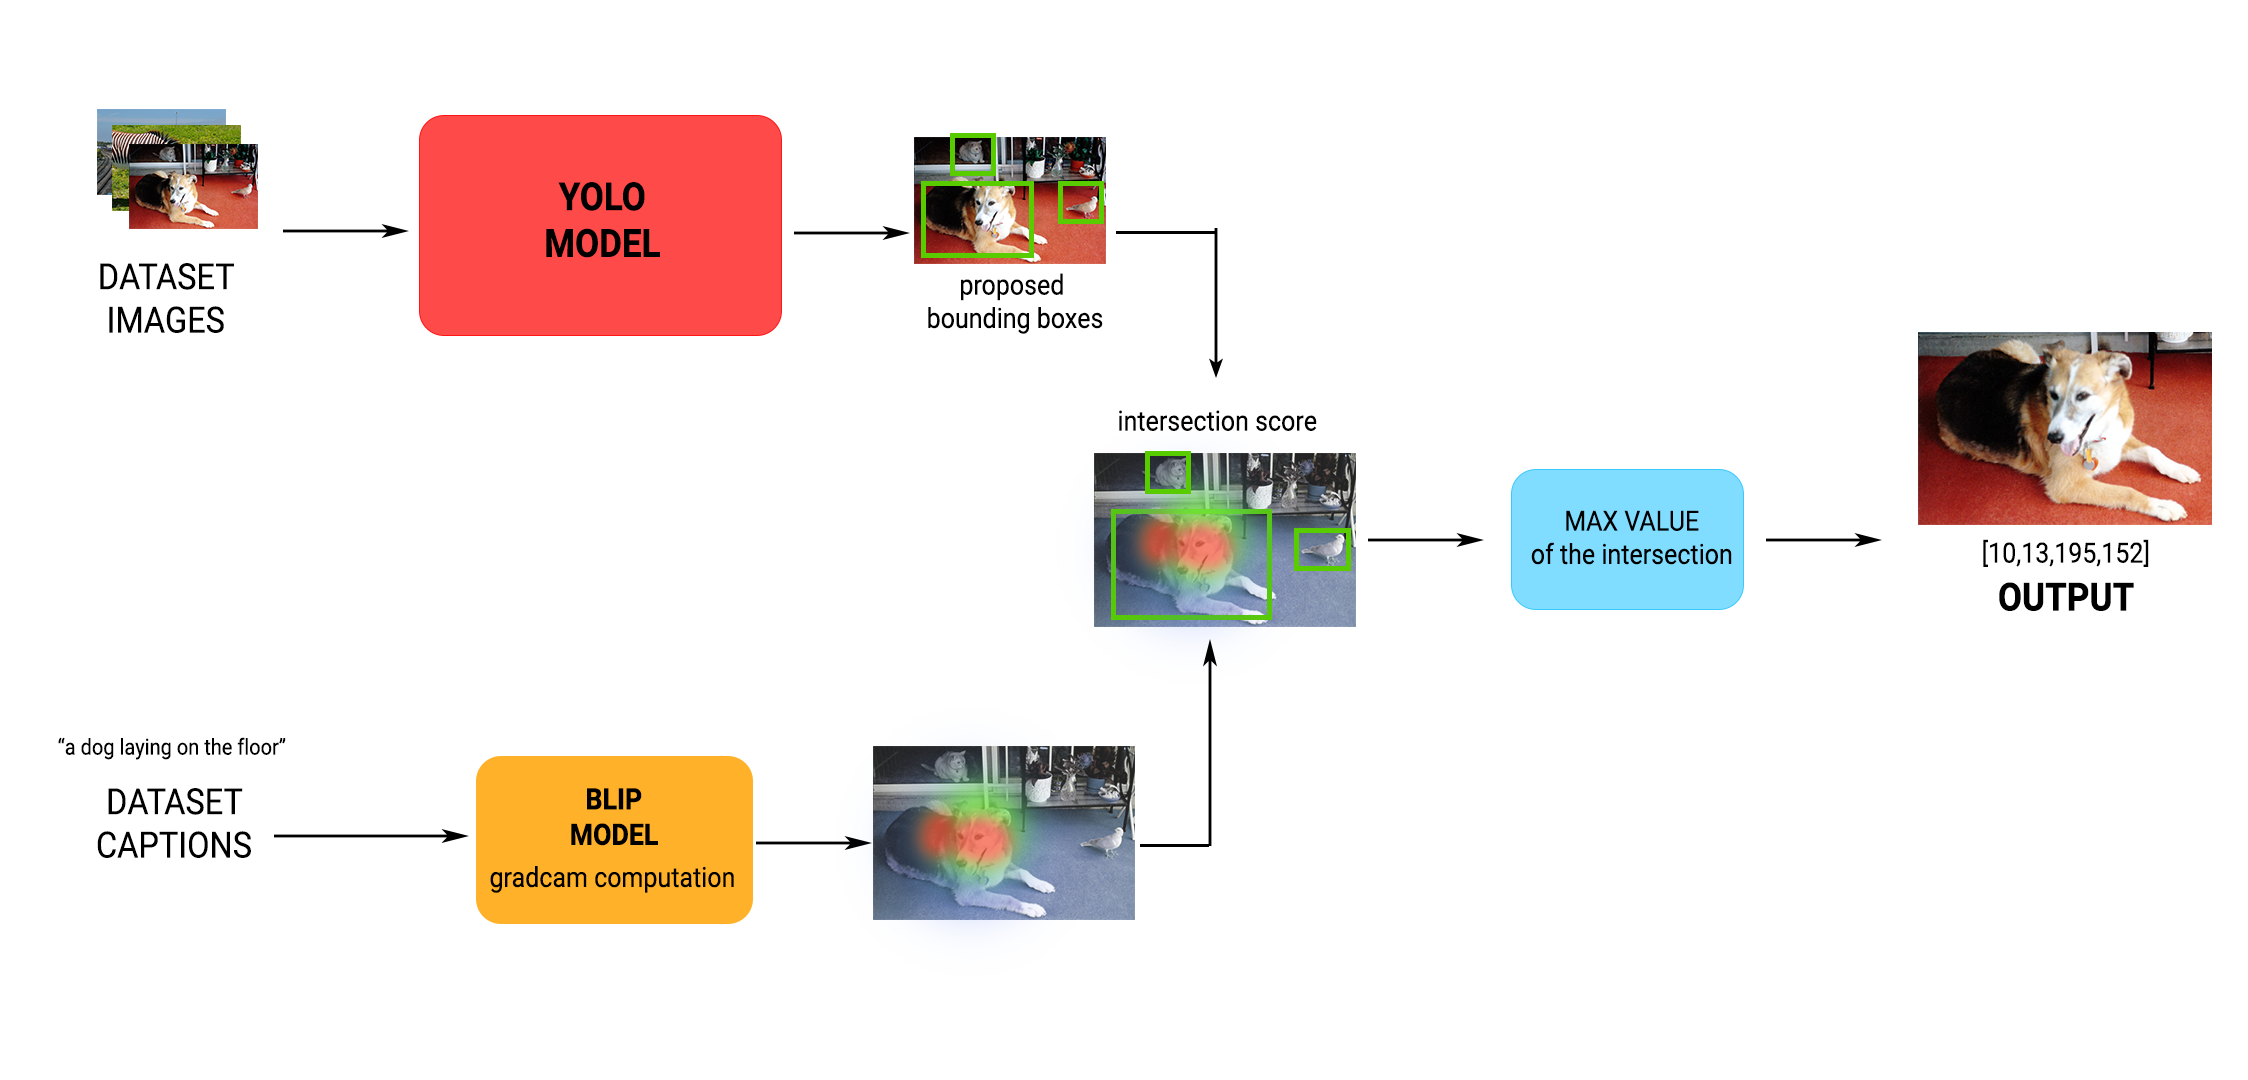

#### GRAD CAM computation

Grad-CAM (Gradient-weighted Class Activation Mapping) is an algorithm used to visualize the class activation maps of a Convolutional Neural Network (CNN). It leverages the gradients of a specific target concept flowing into the final convolutional layer to generate a coarse localization map that highlights the important regions in an image for predicting that concept.

To compute Grad-CAM, the following steps are typically involved:

- Forward Pass: The input image is fed through the CNN, which performs a forward pass to generate the output class probabilities.

- Gradient Calculation: The gradients of the target concept (e.g., the predicted class) with respect to the feature maps of the final convolutional layer are computed. This gradient information indicates the importance of each spatial location in the feature maps for predicting the target concept.

- Global Pooling: The gradients are globally averaged or summed over spatial dimensions to obtain a single value per feature map channel. This step helps to capture the overall importance of each channel for the target concept.

- Weighted Combination: The feature maps of the final convolutional layer are linearly combined with the computed gradients. Each channel of the feature maps is multiplied by its corresponding gradient value, emphasizing the regions that strongly influence the prediction of the target concept.

- ReLU and Upsampling: The resulting activation map is passed through a rectified linear unit (ReLU) to discard negative values. Then, the activation map is upsampled to match the dimensions of the input image, allowing visualization of the localization map.

By applying Grad-CAM, we can obtain a coarse localization map that highlights the regions in an image that contribute the most to the CNN's prediction of a specific target concept, providing insights into the CNN's decision-making process.

#### Motivation
The motivation behind this approach is to explore the differences between using CLIP and BLIP as the foundation block. By using BLIP, we can leverage the entire image as the context for the label, rather than relying solely on individual cropped images for calculating similarity with the caption. This allows us to consider the broader context and potentially capture more relationships between the image and the text.


#### YOLO + BLIP code

In [ ]:
import lavis
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import cv2 # for the premade interpolation function

In [ ]:
# Function to put all the gradcam maps in one

def sum_of_gradcams(gradcam):
    size = gradcam[0][1].shape
    sum_matrix = np.zeros(size)
    for matrix in gradcam[0]:
        sum_matrix = np.add(sum_matrix, matrix)
    return sum_matrix

In [ ]:
# Function to sum all the gradcam values in the bounding box
def sum_values_in_rectangle(matrix, coordinate):
    total_sum = 0
    rows, collums = len(matrix), len(matrix[0])

    coordinate[0] = max(coordinate[0],0)
    coordinate[1] = max(coordinate[1],0)
    coordinate[3] = min(coordinate[3],rows)
    coordinate[2] = min(coordinate[2],collums)

    try:
        for y in (range(coordinate[1], coordinate[3])):
            for x in (range(coordinate[0], coordinate[2])):
                total_sum += matrix[y][x]
    except IndexError:
        print("something is out of the matrix, the coordinates are out of bounds")
        total_sum=1

    return total_sum

In [ ]:
class YOLOBlipModel(torch.nn.Module):
    def __init__(self,device, blip,  yolo_model):
        super().__init__()
        self.device = device

        # Load Yolo
        self.yolo_model = yolo_model

        # Load BLIP
        self.blip_model = blip[0]
        self.blip_image_preprocess = blip[1]
        self.blip_text_preprocess = blip[2]
        self.blip_encoder = blip[3]

    def forward(self, data):
        image, text = [input for input in data]

        results = self.yolo_model(data)

        # Extract patches predicted by YOLO
        columns_to_extract = ['xmin', 'ymin', 'xmax', 'ymax']
        df = results.pandas().xyxy[0]
        boxes = df[columns_to_extract].values.tolist()
        cropped_images, coordinates = cropImage(image, boxes)

        # Blip Preprocess
        input_image = self.blip_image_preprocess["eval"](image).unsqueeze(0).cuda()
        input_text = self.blip_text_preprocess["eval"](text)

        # tokenize text
        text_tokens = self.blip_model.tokenizer(input_text, return_tensors="pt").to('cuda')


        # evaluate the gradcam,

        try:
            with torch.enable_grad():
                gradcam, _ = compute_gradcam( self.blip_model, input_image, input_text, text_tokens, block_num=7)
        except RuntimeError:
            return cropped_images[0], coordinates[0]


        tensor_width, tensor_height = image.size[0], image.size[1]

        # original_width,original_height = pil_image.size
        sum_matrix= np.array(sum_of_gradcams(gradcam))
        resized_attention_map = cv2.resize(sum_matrix, (tensor_width, tensor_height), interpolation=cv2.INTER_LINEAR)

        # summing the values of attention
        max_result= 0
        index_tmp = 0
        for i, coordinate in enumerate(coordinates):
            result = sum_values_in_rectangle(resized_attention_map,coordinate)

            if result >= 1:
                width = coordinate[2] - coordinate[0]  # Calculate the width of the bounding box
                height = coordinate[3] - coordinate[1]  # Calculate the height of the bounding box
                area = width * height
                normalized_value = result/area

                if normalized_value > max_result:
                    max_result = normalized_value
                    index_tmp = i

        return cropped_images[index_tmp], coordinates[index_tmp]


    def get_imageEncoded(self, image):
        image = T.ToPILImage()(image.squeeze(0))
        encoding_preprocess = T.Compose([T.Resize(size=(224, 224)),
                                        T.ToTensor(),
                                        T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
                                        ])
        image = encoding_preprocess(image).unsqueeze(0).to(device)
        sample = {"image": image}
        return self.blip_encoder.extract_features(sample, mode="image").image_embeds

#### YOLO + NLP + BLIP variation

This variation incorporates the NLP classifier developed in the second proposal for the assignment into this approach.

The model pipeline operates as follows:

1. The NLP classifier takes the caption as input and identifies the class of the subject mentioned.
2. The YOLO model is utilized to detect all possible bounding boxes in the image that correspond to the class obtained from the NLP classifier.
3. BLIP is utilized to localize the spatial region in the image that corresponds to the caption by calculating the gradcams.
4. The proposed bounding boxes generated by YOLO are then intersected with the gradcam of the BLIP model.
5. The cropped image, along with the associated coordinates of the bounding box, having the highest score, is selected as the output of the model.


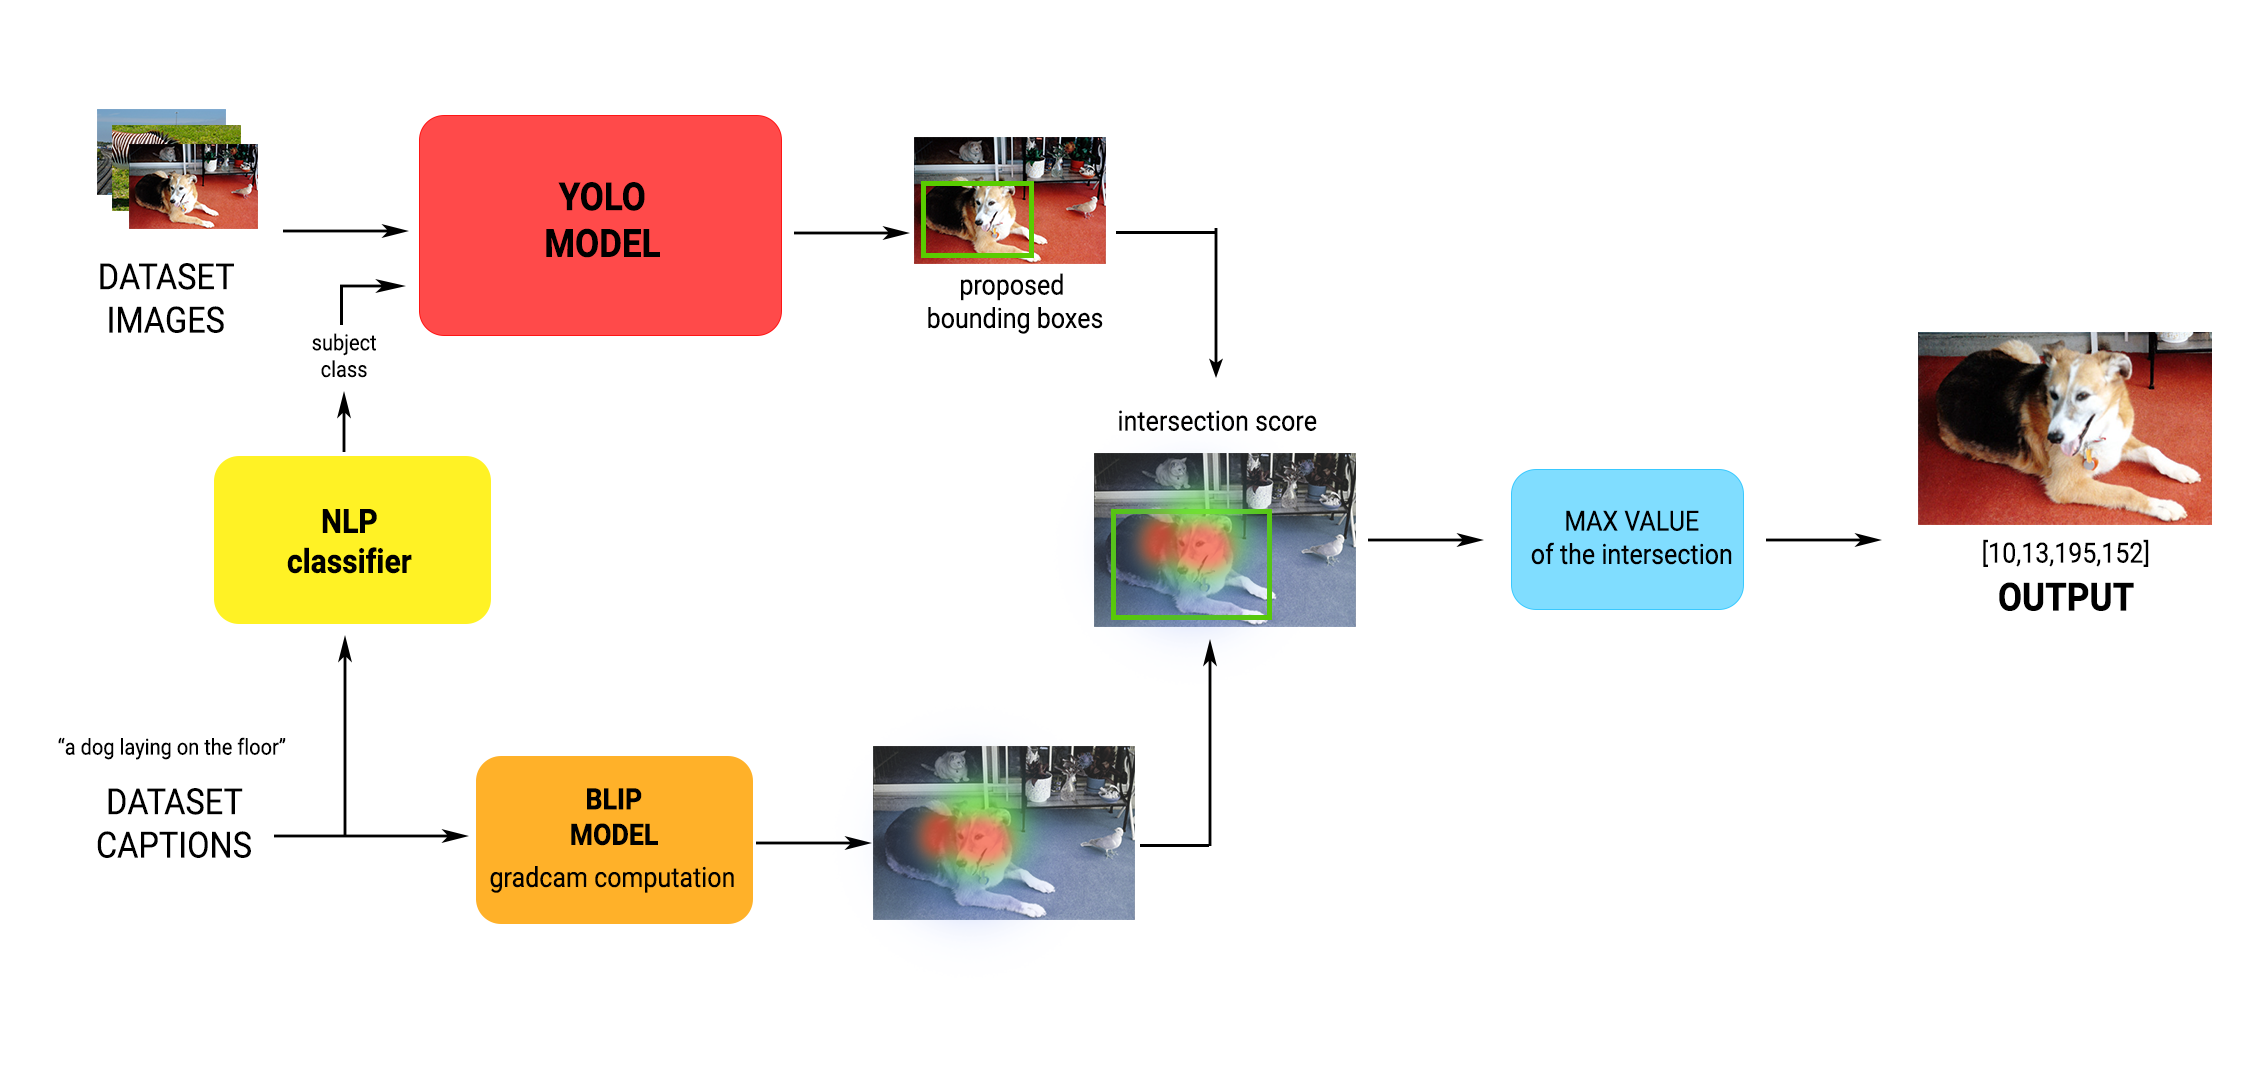

###### variation code

Using the modularity capabilities of PyTorch, this implementation was successfully executed without the need to develop any new modules. The necessary models and modules were appropriately called within the run section of the code.

### 4. DETR + CLIP

#### Model definition
For the last approach, we made a modification to the baseline model by replacing YOLO with DETR (End-to-End Object Detection with Transformers).
DETR is an object detection model that utilizes transformer-based architecture, which has demonstrated impressive performance in various computer vision tasks.

The model pipeline operates as follows:

1. The DETR model is employed to detect all possible objects present in the image.
2. The proposed bounding boxes generated by DETR are then passed to the CLIP model.
3. The CLIP model calculates similarity scores between the cropped image obtained from each bounding box and the corresponding text label.
4. The cropped image, along with the associated coordinates of the bounding box, having the highest similarity score is selected as the output of the model.


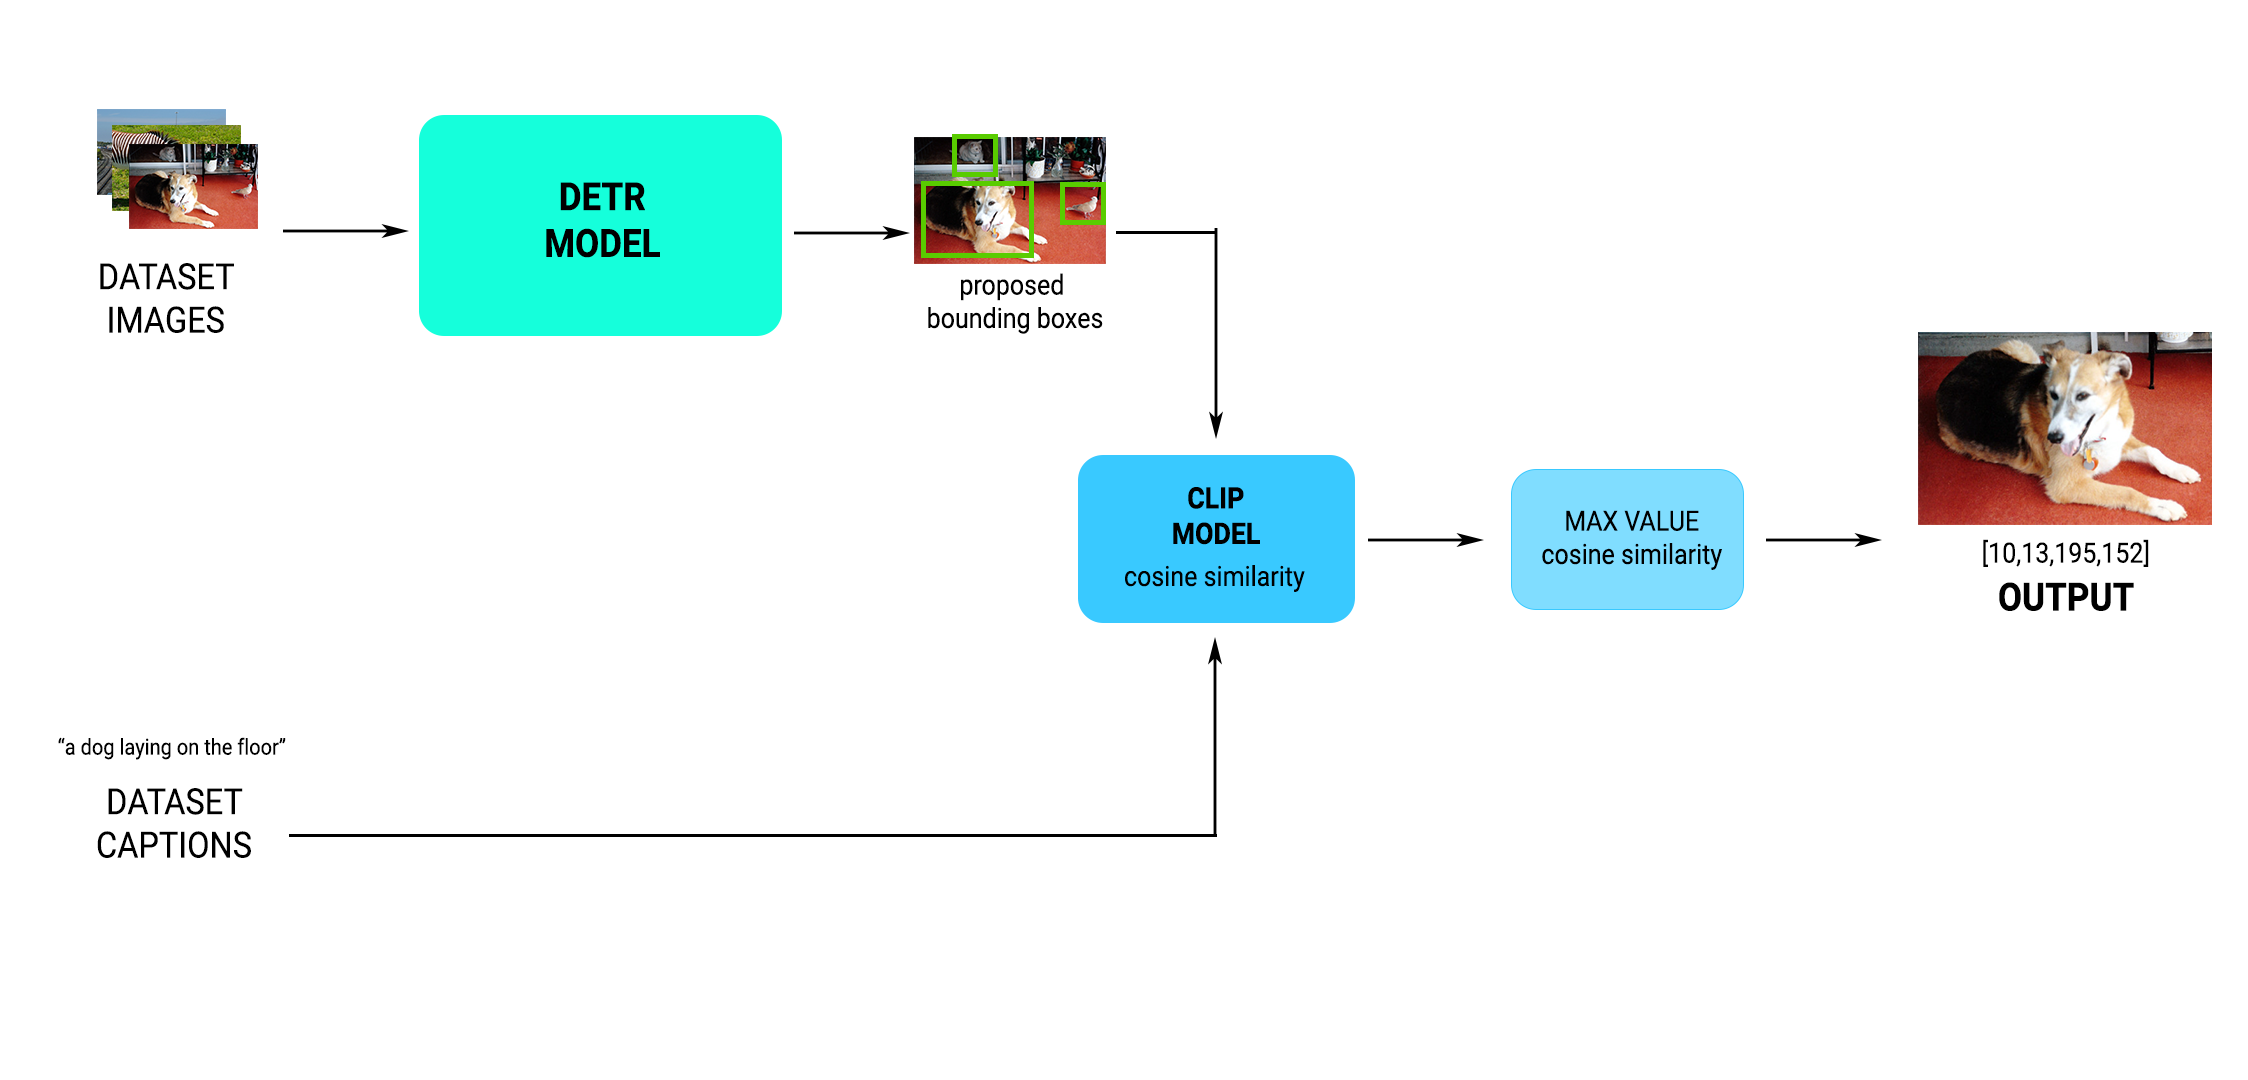

#### DETR


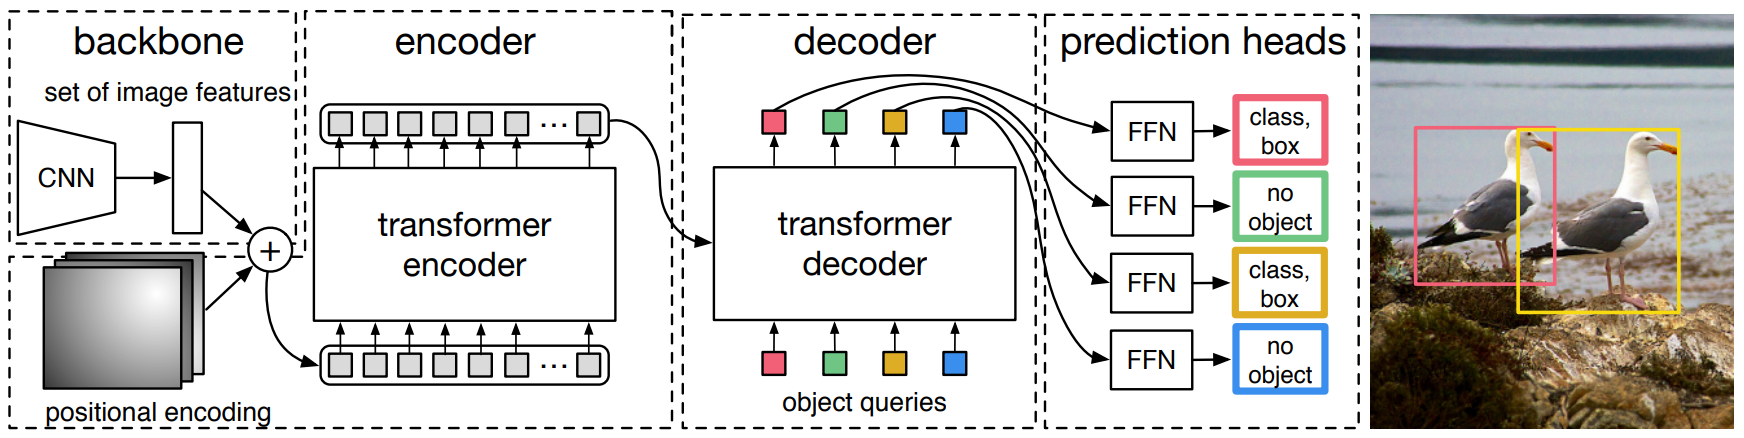

**DETR** (DEtection TRansformer) is an object detection model introduced by Facebook AI in the paper “End-to-End Object Detection with Transformers” by Carion et al.

DETR approaches object detection as a direct set prediction problem and consists of a set-based global loss, which forces unique predictions via bipartite matching, and a Transformer encoder-decoder architecture. DETR combines a CNN (Convolutional Neural Network) with a transformer architecture to detect the final sets of bounding boxes.

The bipartite matching loss is a set-based global loss that forces unique predictions via bipartite matching. Unlike other object detection models that label bounding boxes by matching multiple bounding boxes to one ground truth box, DETR uses a one-vs-one matching approach. During training, bipartite matching uniquely assigns predictions with ground truth boxes.


##### DETR architecture
It contains three main components, which we describe below:
- a CNN backbone to extract a compact feature representation,
- an encoder-decoder transformer,
- a feed forward network (FFN) that makes the final detection prediction

Starting from the initial image, a conventional CNN backbone generates a lower-resolution activation map `f ∈ R^{C×H×W}`, which is a 2D representation of the input image. The model then reduces the channel dimension of the high-level activation map `f` from `C` to a smaller dimension `d`, flattens it, and supplements it to the transformer encoder, resulting in a `d×HW` feature map.

In the transformer architecture, each encoder layer follows a standard design, comprising of a multi-head self-attention module and a feed forward network (FFN). Since the transformer architecture is permutation-invariant, fixed positional encodings are used to encode the feature map.

The transformer decoder takes in a small fixed number of learned positional embeddings, known as object queries, and attends to the encoder output. Each output embedding from the decoder is then passed through a shared feed forward network (FFN), which predicts either a detection (class and bounding box) or a “no object” class.



#### DETR + CLIP code

##### CNN, encoder decoder transformer of DETR

In [ ]:
from torchvision.models import resnet50

class VisualFeatureExtractor(torch.nn.Module):
    def __init__(self,
                 device,
                 num_classes = 91,
                 hidden_dim=256,
                 nheads=8,
                 num_encoder_layers=6,
                 num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, image):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(image)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer (encoder part)
        encoded_features = self.transformer.encoder(pos + 0.1 * h.flatten(2).permute(2, 0, 1))

        # propagate the encoded features through the transformer decoder
        decoded_features = self.transformer.decoder(
           self.query_pos.unsqueeze(1), encoded_features).transpose(0, 1)

        bbs = self.linear_bbox(decoded_features).sigmoid()
        pred_logits = self.linear_class(decoded_features)
        pred_logits = pred_logits.softmax(-1)[0, :, :-1]
        scores = pred_logits.max(-1).values
        keep = pred_logits.max(-1).values > 0.1

        bbs = bbs.squeeze(0)
        bbs_masked = bbs[keep]

        scores_masked = scores[keep]
        return bbs_masked, scores_masked, encoded_features

##### model

In [ ]:
class DetrClip(torch.nn.Module):
    def __init__(self, device, clip_model):
        super().__init__()
        self.device = device
        self.clip_model = clip_model
        self.clip_model.eval()

        self.transformDert = T.Compose([T.ToTensor(), T.Resize((640, 640),antialias=True)])
        self.transformClip = T.Compose([
            T.Resize((224, 224), antialias=True),
            T.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711])
        ])

        # Load VisualFeatureExtractor weights
        self.detr = VisualFeatureExtractor(device, num_classes=91)
        state_dict = torch.hub.load_state_dict_from_url(url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth', map_location=device, check_hash=True)
        self.detr.load_state_dict(state_dict, strict=False)
        self.detr.eval()
        self.detr.to(device)


    def forward(self, data):
        image, text = [input for input in data]

        image_dert = self.transformDert(image).to(self.device)
        image_dert = image_dert.unsqueeze(0)

        bbs, scores, encoded_features = self.detr(image_dert) # Fv [HxW , batch_size, C=256]

        bboxes_scaled = rescale_bboxes(bbs , image.size, self.device)

        bboxes_scaled = getUniqueBoxes(bboxes_scaled,scores, 0.9)

        cropped_images, coordinates = cropImage(image, bboxes_scaled)

        return performCLIP(self, self.device, text, cropped_images, coordinates)

    def get_imageEncoded(self, image):
        resize = T.Resize((640, 640))
        image_dert = resize(image).to(self.device)

        _, _, encoded_features = self.detr(image_dert)
        return encoded_features

#### Motivation

The initial motivation for our model was derived from the paper titled "Improving Visual Grounding with Visual-Linguistic Verification and Iterative Reasoning" by Li Yang et al.
Initially, we implemented a basic version of this model in a separate notebook. However, due to limited resources and extended training time, we had to change our approach.

During the implementation of the aforementioned model, we discovered DETR, a model for object detection, used as the feature extractor of the paper.
Consequently, we replaced YOLO with DETR as our object detection model in the baseline.
Additionally, drawing inspiration from the same paper, we aimed to enhance the features extracted by the DETR CNN and encoder by introducing a new block.

Unfortunately, the results obtained from this approach were not as promising as anticipated. Consequently, we decided to discontinue pursuing this direction.
In the following section, we provide a brief overview of the model we attempted to examine.


#### DERT MODIFIED + CLIP
The model pipeline operates as follows:

1. The BERT model is utilized to obtain the text embedding vector.
2. A linear layer is employed to reduce the dimensionality of the textual embedding.
3. The DETR model is employed to detect all possible objects present in the image.
4. The proposed bounding boxes generated by DETR are then passed to the CLIP model.
5. The CLIP model calculates similarity scores between the cropped image obtained from each bounding box and the corresponding text label.
6. The cropped image, along with the associated coordinates of the bounding box, having the highest similarity score is selected as the output of the model.


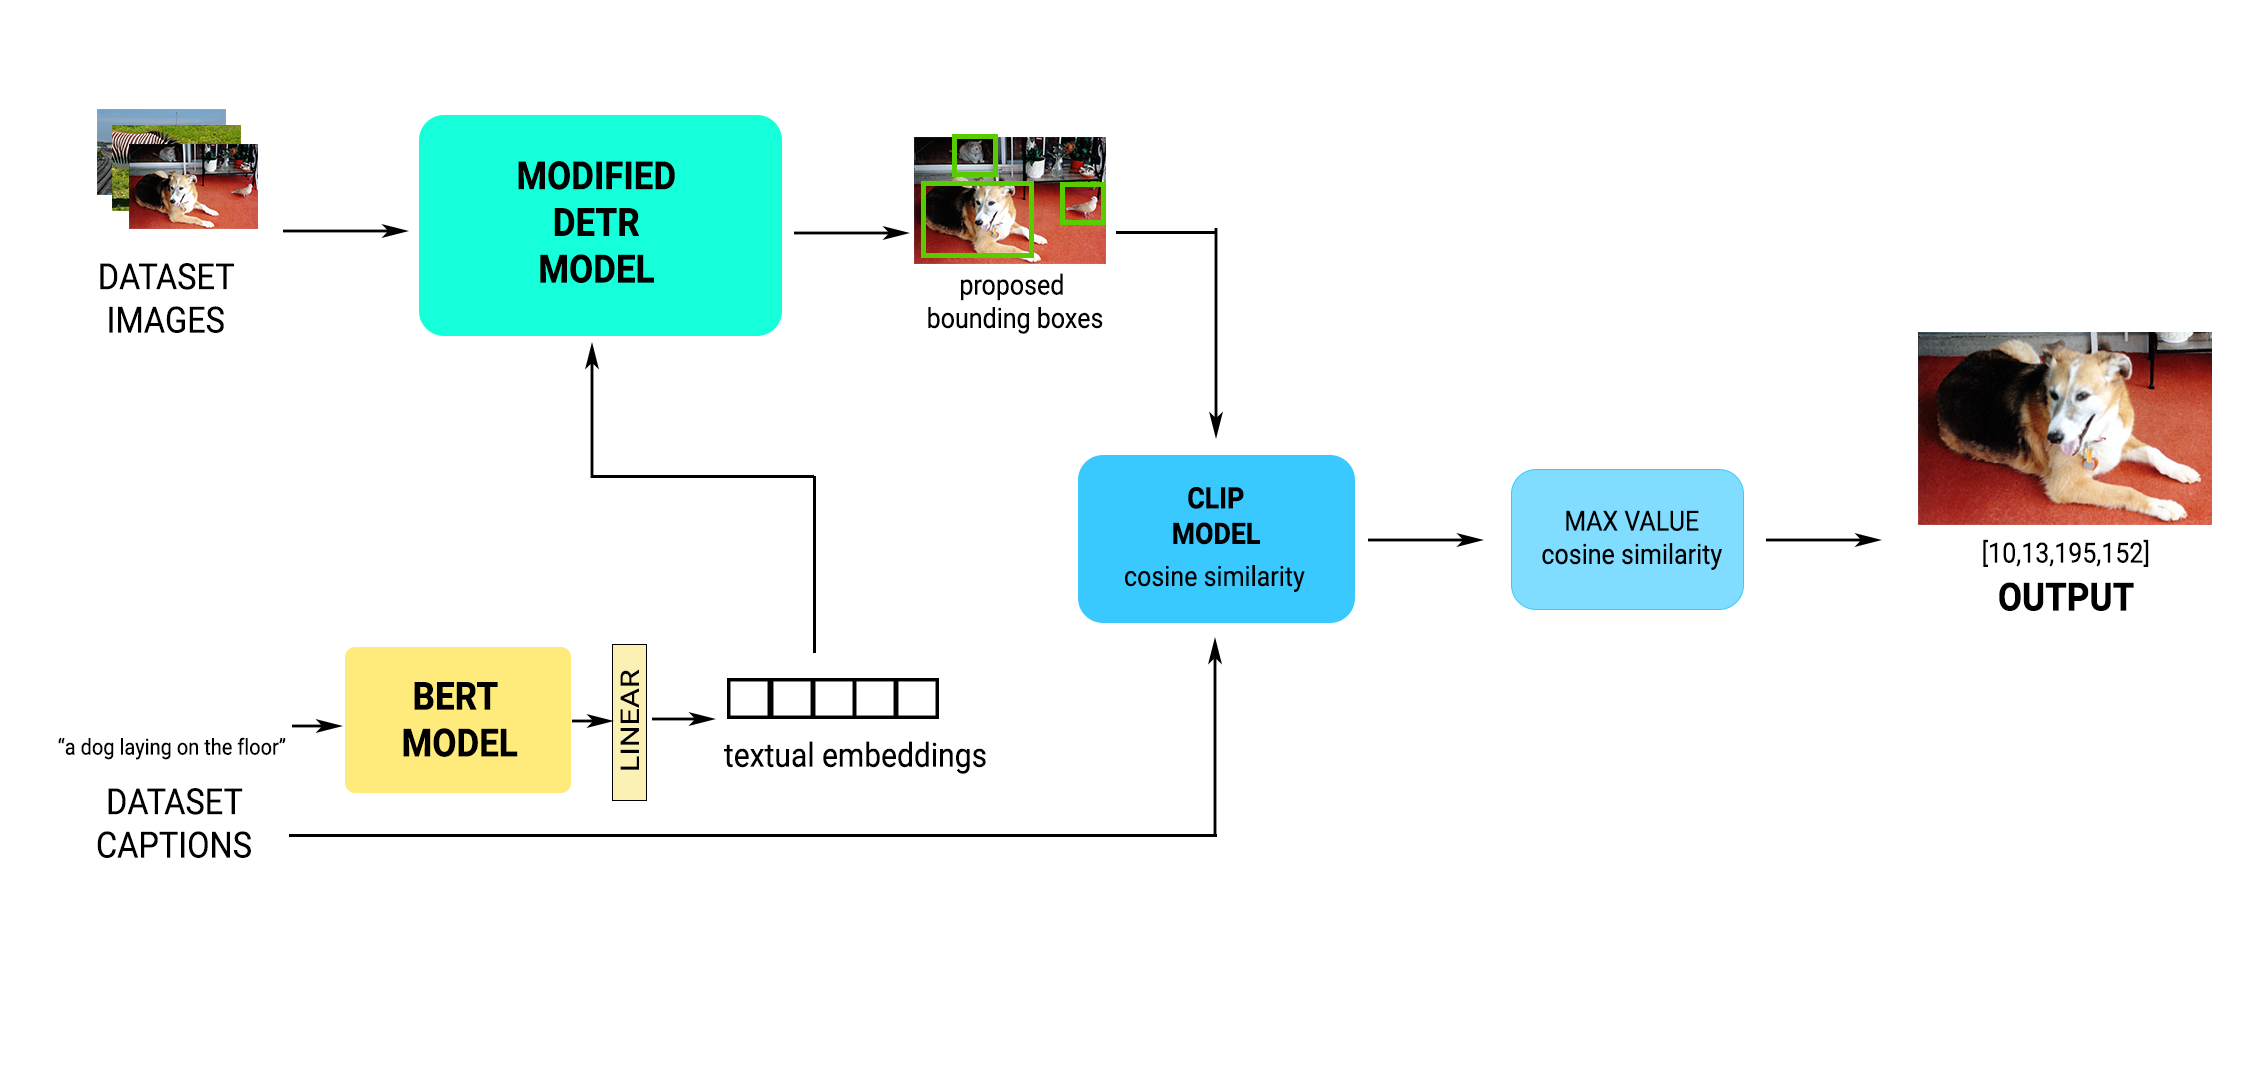

The modified DETR model differs from the original version by incorporating additional layers between the transformer encoder and the transformer decoder.

This added layer is based on multi-head attention. In this configuration, the visual features map serves as the query, while the textual embeddings act as the key and value. Through multi-head attention, relevant semantic features are gathered from the textual embeddings for each visual feature vector in the visual feature map. The resulting semantic map and visual features are then combined to generate enhanced feature representations. These enhanced feature representations are subsequently utilized in the transformer decoder.

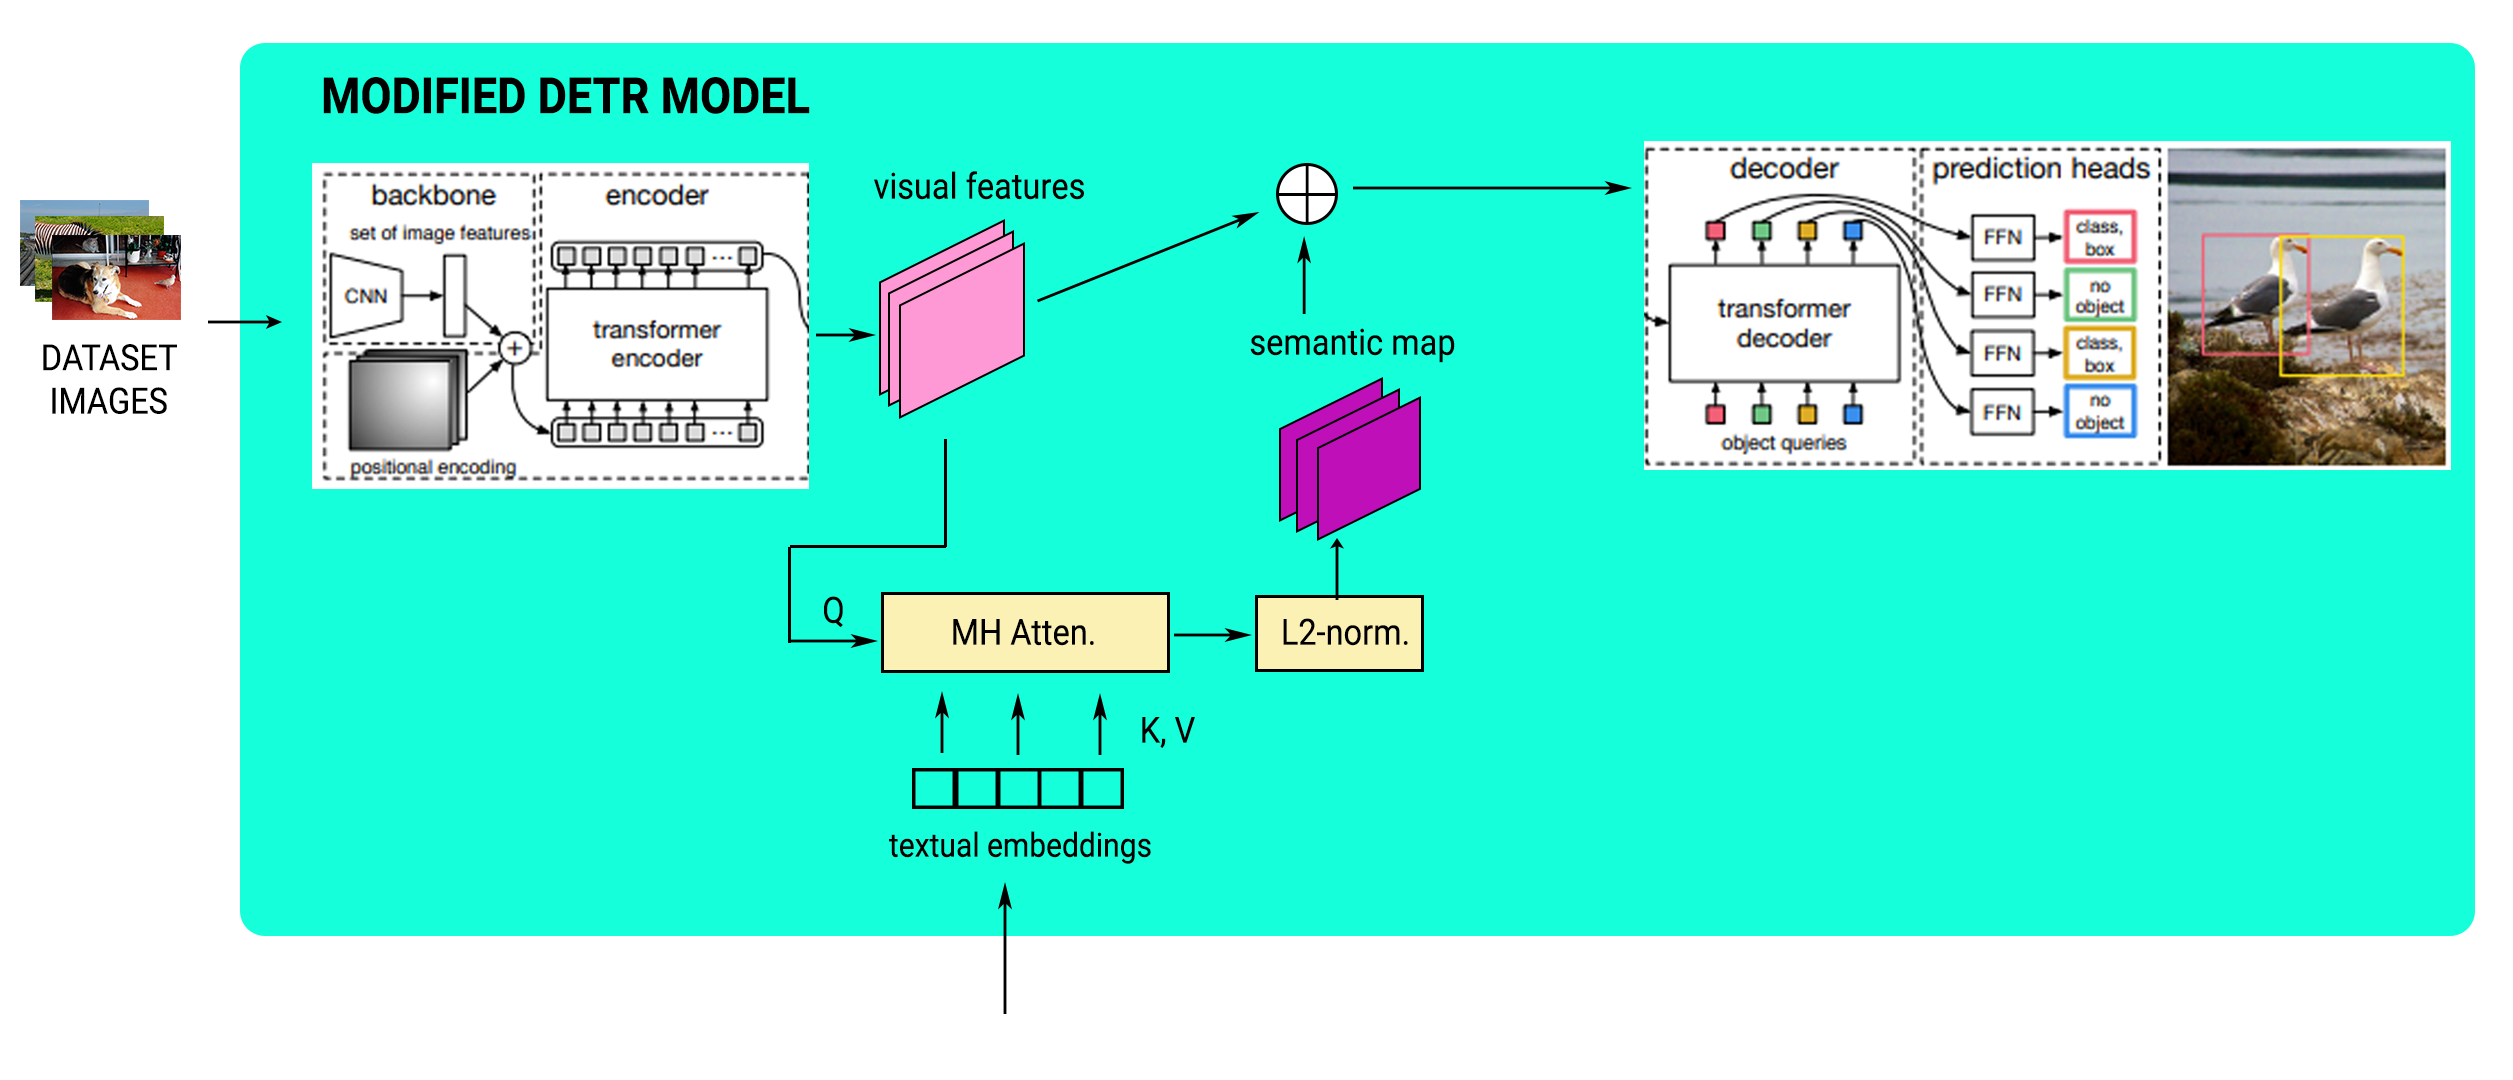

##### Motivation
As mentioned earlier, the results obtained from testing this approach were not satisfactory, likely due to resource and time constraints.
Consequently, we made the strategic decision to allocate our focus to other components of this assignment.

Despite the suboptimal outcomes, we made the decision to describe this approach in detail for future examination and additional testing.


## METRICS
The metrics used for this project, as suggested in the assignment paper, are Intersection over Union (IoU) for localization accuracy, recall for grounding accuracy, and Cosine similarity and Euclidean distance for semantic similarity.
- Localization accuracy measures how accurately the system can localize an object in the image.
- Grounding accuracy measures how accurately the system can ground the localized object to a language description.
- Semantic similarity measures the similarity between the predicted bounding boxes and the ground-truth descriptions.

The metrics used for this project are as follows:


### Intersection over Union (IoU)

Intersection over Union (IoU) is a metric commonly used to measure the overlap between two bounding boxes or regions of interest. It is calculated by dividing the area of overlap between the predicted and ground-truth bounding boxes by the area of their union. IoU provides a measure of how well the predicted bounding box aligns with the ground truth.


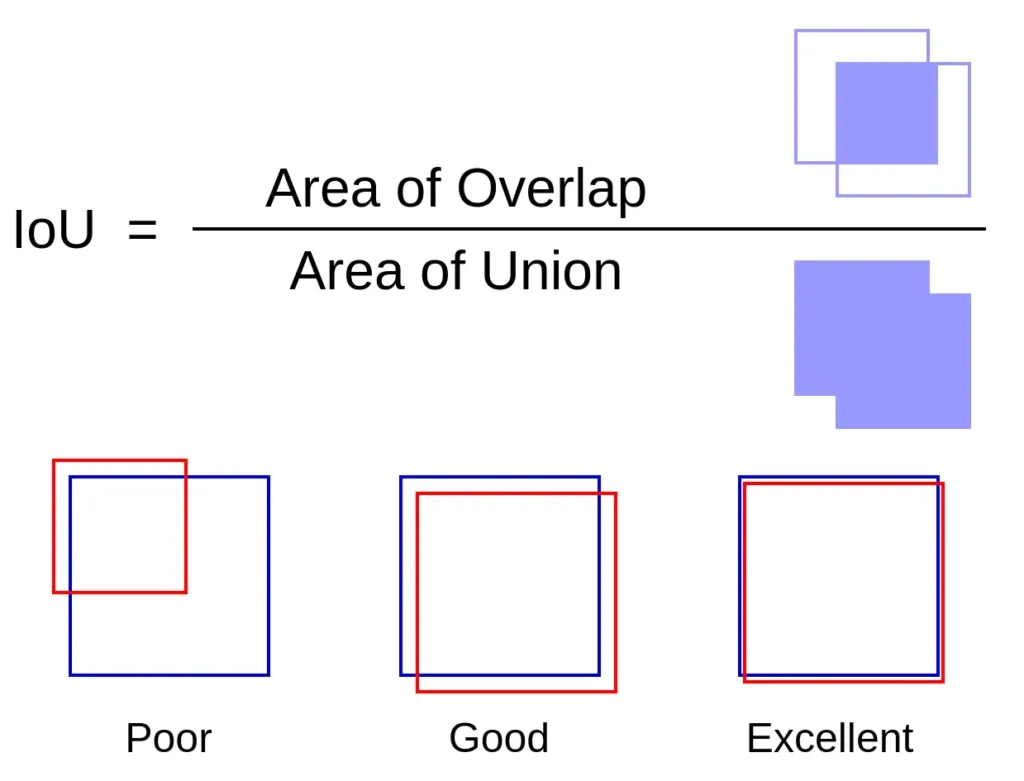

image source: https://idiotdeveloper.com/what-is-intersection-over-union-iou/

### Recall

Recall is a measure of how many relevant instances were correctly retrieved. It is calculated as the number of true positives divided by the total number of instances that actually belong to the positive class (i.e., the sum of true positives and false negatives). In our case it is calculated as the number of true positives samples divided by all the samples.

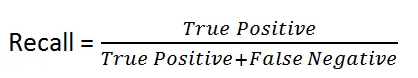

image source: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

### Cosine Similarity

Cosine similarity is a measure of similarity between two non-zero vectors defined in an inner product space. It is calculated as the cosine of the angle between the vectors; that is, it is the dot product of the vectors divided by the product of their lengths. In the context of semantic similarity, it calculates the cosine of the angle between two vector representations of the predicted and ground-truth descriptions. The resulting value ranges from -1 to 1, with a higher value indicating greater similarity between the descriptions.

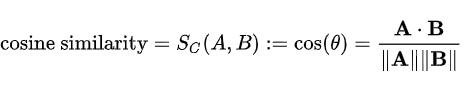

image source: https://en.wikipedia.org/wiki/Cosine_similarity

### Euclidean Distance

Euclidean distance is a measure of distance between two points in Euclidean space. It can be calculated from the Cartesian coordinates of the points using the Pythagorean theorem.


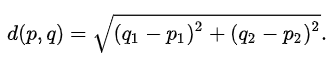

In higher dimensions, for points given by Cartesian coordinates in n-dimensional Euclidean space, it is calculated as square root of sum of squares of differences between corresponding coordinates.


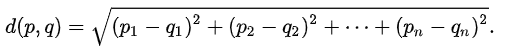

images source: https://en.wikipedia.org/wiki/Euclidean_distance

In [ ]:
from torchvision.ops import box_iou

def computeMetrics(image, computed, target, encoder):
    imageGT, _ = cropImage(image, [target])
    #LOCALIZATION ACCURACY -> IOU
    bbComputed = torch.tensor(computed[1]).unsqueeze(0) #box_iou need tensor of shape [N,4]
    bbTarget = torch.tensor(target).unsqueeze(0)

    iou = box_iou(bbComputed, bbTarget)

    #SEMANTIC ACCURACY -> COSINE SIMILARITY
    targetEmbed = encoder(imageGT[0])
    computedEmbed = encoder(computed[0])

    # Compute the cosine similarity between the flattened vectors
    cos_sim= F.cosine_similarity(targetEmbed.flatten(), computedEmbed.flatten(), dim=0)

    #SEMANTIC ACCURACY -> EUCLIDEAN DISTANCE
    eucl_dist = F.pairwise_distance(targetEmbed.flatten(), computedEmbed.flatten())

    return iou.item(), cos_sim.item(), eucl_dist.item()

## EVALUATE
This function is utilized to evaluate a given model by providing the model itself and the corresponding dataloader as inputs.

In [ ]:
from tqdm import tqdm
from datetime import datetime

# Evaluate model on given metrics
def evaluate(model, data_loader):
    samples = len(data_loader.dataset)
    print(f'Element to evaluate: {samples}')

    output_df = pd.DataFrame(columns=['iou', 'cosSim', 'EuclDist'])

    # Create a progress bar using tqdm
    progress_bar = tqdm(total=samples, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', position=0, leave=True)

    with torch.no_grad():
        # iterate over the test set
        for batch_idx, (ids, datas, targets) in enumerate(data_loader):
            for id, data, target in zip(ids, datas, targets):
                image , text = [d for d in data]

                # forward pass
                output = model([image, text])

                # evaluation metrics
                iou, cosSim , euclDist = computeMetrics(image, output, target, model.get_imageEncoded)

                # add to dataframe
                output_df.loc[id] = [iou, cosSim , euclDist]

                # Update the progress bar
                progress_bar.update(1)

    progress_bar.close()

    # Compute metrics
    recall = ((output_df['iou'] > .5).sum()) / (len(output_df['iou']))
    meanIou = output_df['iou'].mean()
    meanCosSim = output_df['cosSim'].mean()
    meanEuclDist = output_df['EuclDist'].mean()

    time = datetime.now().time().strftime("%H:%M")
    output_df.to_csv(f"{model.__class__.__name__}_{time}.csv", index=False)

    print()
    print('--------------------------METRICS--------------------------')
    print()
    print(f"Recall: {recall}; Mean IoU: {meanIou}; Mean Cosine Similarity: {meanCosSim}; Mean Euclidean Distance: {meanEuclDist}")

 This cell sets up the necessary models, loads pre-trained weights, and prepares the data for further evaluation.

In [ ]:
# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the pre-trained YOLO model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

if torch.cuda.is_available():
    yolo_model.cuda().eval()
else:
    yolo_model.eval()

for param in yolo_model.parameters():
    param.requires_grad = False

yolo_param = {'conf' : 0.2,  # NMS confidence threshold
        'iou' : 0.05,  # NMS IoU threshold
        'max_det' : 10  # maximum number of detections per image
}
# Load the pre-trained CLIP model
clip_model, _ = clip.load("RN50", device=device)

clip_preprocess = T.Compose([
            T.Resize((224, 224)),
            T.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711])
        ])

if torch.cuda.is_available():
    clip_model = clip_model.cuda().eval()
else:
    clip_model = clip_model.eval()

dataloader = get_data('val', batch_size = 1)

Using device: cuda


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-17 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Valset len: 4896


## MODEL EVALUATION AND COMPARISON


### 1.BASELINE

In [ ]:
baseline = YOLOClipModel(device, yolo_model, clip_model, yolo_param,  clip_preprocess)
evaluate(baseline, dataloader)

Element to evaluate: 4896


100%|██████████| 4896/4896 [13:09<00:00,  6.20it/s]



--------------------------METRICS--------------------------

Recall: 0.5488153594771242; Mean IoU: 0.5262144362482253; Mean Cosine Similarity: 0.8731247147703483; Mean Euclidean Distance: 0.8639404197144352


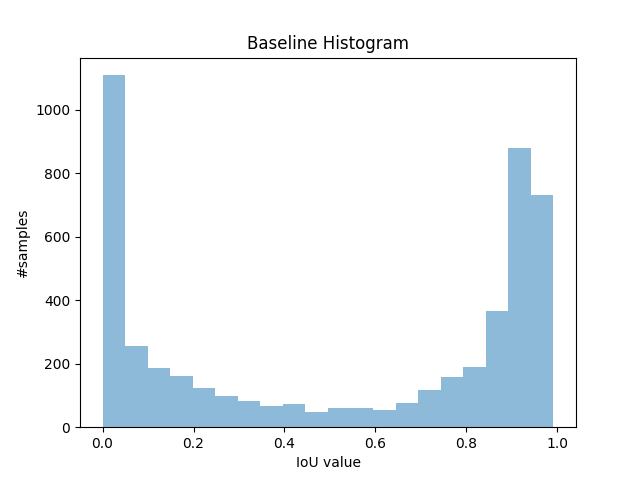

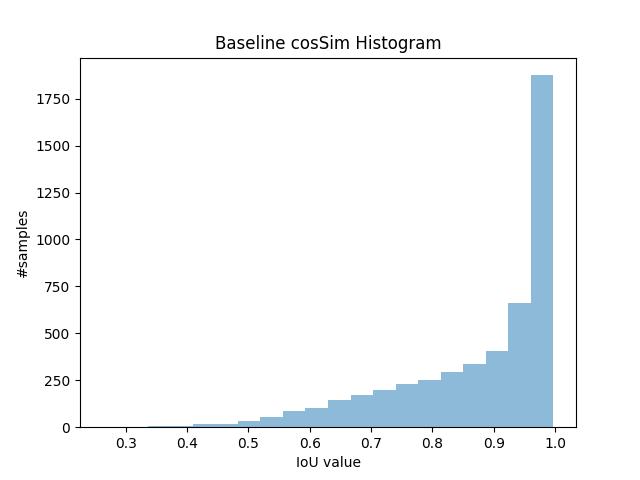

The performance of the model in the baseline experiment was found to be satisfactory.

Regarding the cosine similarity values, it is evident that the majority of the distribution is centered on high values. This is expected since, according to the metric's definition, even when the bounding box is inaccurate but the subject belongs to the same class, the similarity score remains high.

Conversely, when considering the intersection over union metric, the values tend to vary widely, ranging from near zero to near one. This metric provides a clearer distinction between results as it focuses on the positional differences within the image, rather than considering semantic similarities between the images.

### 2.BASELINE + NLP classifier

In [ ]:
BERT_Baseline = BERT_BaseModel(device, yolo_model, clip_model, yolo_param,  clip_preprocess)
clear_output()
evaluate(BERT_Baseline, dataloader)

Element to evaluate: 4896


  0%|          | 1/4896 [00:00<38:33,  2.12it/s]

3


  0%|          | 2/4896 [00:00<26:21,  3.10it/s]

3


  0%|          | 3/4896 [00:00<23:42,  3.44it/s]

3


  0%|          | 4/4896 [00:01<22:15,  3.66it/s]

3


  0%|          | 5/4896 [00:01<22:20,  3.65it/s]

3
3


  0%|          | 6/4896 [00:01<23:25,  3.48it/s]

1


  0%|          | 8/4896 [00:02<27:53,  2.92it/s]

1


  0%|          | 10/4896 [00:02<18:54,  4.31it/s]

2
2


  0%|          | 12/4896 [00:03<14:17,  5.70it/s]

1
1


  0%|          | 13/4896 [00:03<14:03,  5.79it/s]

4
4


  0%|          | 16/4896 [00:03<11:27,  7.10it/s]

1
1


  0%|          | 18/4896 [00:03<10:38,  7.64it/s]

1
1


  0%|          | 19/4896 [00:04<14:13,  5.72it/s]

10


  0%|          | 21/4896 [00:04<11:52,  6.84it/s]

1
1


  0%|          | 23/4896 [00:04<10:34,  7.68it/s]

1
1


  1%|          | 25/4896 [00:04<10:49,  7.50it/s]

2
2


  1%|          | 27/4896 [00:05<10:17,  7.89it/s]

2
1


  1%|          | 29/4896 [00:05<10:20,  7.85it/s]

1
2


  1%|          | 30/4896 [00:05<10:25,  7.78it/s]

2
3


  1%|          | 32/4896 [00:05<13:30,  6.00it/s]

10
2


  1%|          | 34/4896 [00:06<11:59,  6.76it/s]

2
10


  1%|          | 36/4896 [00:06<15:31,  5.22it/s]

10
2


  1%|          | 39/4896 [00:07<11:59,  6.75it/s]

2
2


  1%|          | 41/4896 [00:07<10:56,  7.40it/s]

2
1


  1%|          | 43/4896 [00:07<10:50,  7.46it/s]

2
2


  1%|          | 45/4896 [00:07<10:35,  7.63it/s]

2
2


  1%|          | 46/4896 [00:07<10:46,  7.51it/s]

2
2


  1%|          | 48/4896 [00:08<11:13,  7.20it/s]

2
2


  1%|          | 50/4896 [00:08<11:18,  7.15it/s]

3
1


  1%|          | 52/4896 [00:08<12:12,  6.61it/s]

1
2


  1%|          | 54/4896 [00:09<14:33,  5.54it/s]

2
3


  1%|          | 56/4896 [00:09<15:24,  5.24it/s]

3
1


  1%|          | 58/4896 [00:10<14:58,  5.39it/s]

1
2


  1%|          | 60/4896 [00:10<15:44,  5.12it/s]

2
10


  1%|▏         | 62/4896 [00:10<18:01,  4.47it/s]

2
1


  1%|▏         | 64/4896 [00:11<16:07,  4.99it/s]

1
1


  1%|▏         | 66/4896 [00:11<15:25,  5.22it/s]

1
2


  1%|▏         | 68/4896 [00:12<15:06,  5.33it/s]

2
3


  1%|▏         | 70/4896 [00:12<15:41,  5.13it/s]

3


  1%|▏         | 71/4896 [00:12<15:55,  5.05it/s]

2
2


  1%|▏         | 73/4896 [00:13<16:16,  4.94it/s]

2


  2%|▏         | 74/4896 [00:13<16:15,  4.94it/s]

2
1

  2%|▏         | 75/4896 [00:13<15:57,  5.04it/s]


1


  2%|▏         | 77/4896 [00:13<15:20,  5.23it/s]

1
1


  2%|▏         | 79/4896 [00:14<15:25,  5.21it/s]

1
3


  2%|▏         | 81/4896 [00:14<16:55,  4.74it/s]

3


  2%|▏         | 82/4896 [00:14<16:45,  4.79it/s]

2
2


  2%|▏         | 84/4896 [00:15<16:25,  4.88it/s]

2
1


  2%|▏         | 87/4896 [00:15<12:17,  6.52it/s]

1
1


  2%|▏         | 89/4896 [00:15<11:19,  7.08it/s]

1
2


  2%|▏         | 91/4896 [00:16<10:31,  7.61it/s]

2
1


  2%|▏         | 93/4896 [00:16<10:16,  7.80it/s]

1
1


  2%|▏         | 95/4896 [00:16<10:02,  7.97it/s]

1
1


  2%|▏         | 97/4896 [00:16<10:08,  7.88it/s]

1
2


  2%|▏         | 98/4896 [00:17<10:15,  7.80it/s]

2
4


  2%|▏         | 100/4896 [00:17<10:33,  7.57it/s]

1
3


  2%|▏         | 103/4896 [00:17<10:33,  7.56it/s]

3
1


  2%|▏         | 104/4896 [00:17<10:26,  7.65it/s]

1
2


  2%|▏         | 106/4896 [00:18<10:35,  7.53it/s]

2
3


  2%|▏         | 108/4896 [00:18<11:03,  7.21it/s]

3
1


  2%|▏         | 111/4896 [00:18<10:44,  7.43it/s]

1
3


  2%|▏         | 112/4896 [00:18<10:43,  7.43it/s]

3
10


  2%|▏         | 114/4896 [00:19<12:03,  6.61it/s]

1
10


  2%|▏         | 116/4896 [00:19<15:25,  5.17it/s]

10


  2%|▏         | 117/4896 [00:19<13:53,  5.73it/s]

2
2


  2%|▏         | 120/4896 [00:20<11:41,  6.81it/s]

1
3


  2%|▏         | 121/4896 [00:20<11:26,  6.96it/s]

3
1


  3%|▎         | 123/4896 [00:20<10:32,  7.55it/s]

1
3


  3%|▎         | 125/4896 [00:20<10:55,  7.28it/s]

3
2


  3%|▎         | 128/4896 [00:21<10:17,  7.72it/s]

2
1


  3%|▎         | 130/4896 [00:21<10:04,  7.88it/s]

1
2


  3%|▎         | 131/4896 [00:21<10:20,  7.68it/s]

2
3


  3%|▎         | 133/4896 [00:21<10:35,  7.49it/s]

3
1


  3%|▎         | 136/4896 [00:22<10:05,  7.87it/s]

1
1


  3%|▎         | 138/4896 [00:22<09:43,  8.15it/s]

1
1


  3%|▎         | 139/4896 [00:22<09:45,  8.12it/s]

1
2


  3%|▎         | 141/4896 [00:22<10:18,  7.69it/s]

2
3


  3%|▎         | 143/4896 [00:23<10:36,  7.47it/s]

3
2


  3%|▎         | 145/4896 [00:23<10:42,  7.40it/s]

2
1


  3%|▎         | 147/4896 [00:23<11:02,  7.17it/s]

1
4


  3%|▎         | 149/4896 [00:24<11:27,  6.90it/s]

4
2


  3%|▎         | 152/4896 [00:24<10:32,  7.50it/s]

2
1


  3%|▎         | 153/4896 [00:24<12:58,  6.09it/s]

10


  3%|▎         | 154/4896 [00:24<12:58,  6.09it/s]

3
3


  3%|▎         | 156/4896 [00:25<12:13,  6.47it/s]

3
3


  3%|▎         | 158/4896 [00:25<13:44,  5.75it/s]

2
4


  3%|▎         | 160/4896 [00:26<15:43,  5.02it/s]

3
3


  3%|▎         | 162/4896 [00:26<15:08,  5.21it/s]

1
1


  3%|▎         | 164/4896 [00:26<15:16,  5.16it/s]

2
2


  3%|▎         | 166/4896 [00:27<15:04,  5.23it/s]

1
1


  3%|▎         | 168/4896 [00:27<15:16,  5.16it/s]

4


  3%|▎         | 169/4896 [00:27<16:09,  4.87it/s]

4
2

  3%|▎         | 170/4896 [00:28<15:58,  4.93it/s]


2

  3%|▎         | 171/4896 [00:28<15:50,  4.97it/s]


2


  4%|▎         | 173/4896 [00:28<15:47,  4.98it/s]

3


  4%|▎         | 174/4896 [00:28<15:35,  5.05it/s]

2
2


  4%|▎         | 176/4896 [00:29<15:26,  5.09it/s]

1
1


  4%|▎         | 178/4896 [00:29<15:46,  4.99it/s]

2


  4%|▎         | 179/4896 [00:29<16:11,  4.86it/s]

2


  4%|▎         | 180/4896 [00:30<16:07,  4.88it/s]

2


  4%|▎         | 181/4896 [00:30<16:20,  4.81it/s]

2
3


  4%|▎         | 183/4896 [00:30<16:24,  4.79it/s]

3


  4%|▍         | 184/4896 [00:30<16:58,  4.63it/s]

2


  4%|▍         | 185/4896 [00:31<17:20,  4.53it/s]

2


  4%|▍         | 186/4896 [00:31<17:17,  4.54it/s]

2


  4%|▍         | 187/4896 [00:31<17:08,  4.58it/s]

2


  4%|▍         | 188/4896 [00:31<16:50,  4.66it/s]

1
2


  4%|▍         | 190/4896 [00:32<14:14,  5.51it/s]

2
2


  4%|▍         | 192/4896 [00:32<12:37,  6.21it/s]

2
2


  4%|▍         | 194/4896 [00:32<11:31,  6.80it/s]

2
2


  4%|▍         | 197/4896 [00:33<10:59,  7.12it/s]

2
2


  4%|▍         | 198/4896 [00:33<10:50,  7.22it/s]

2
2


  4%|▍         | 200/4896 [00:33<10:49,  7.23it/s]

2
2


  4%|▍         | 203/4896 [00:33<10:31,  7.43it/s]

2
2


  4%|▍         | 205/4896 [00:34<10:15,  7.62it/s]

2
1


  4%|▍         | 207/4896 [00:34<10:07,  7.72it/s]

1
2


  4%|▍         | 208/4896 [00:34<10:08,  7.70it/s]

2
2


  4%|▍         | 211/4896 [00:34<10:14,  7.62it/s]

2
3


  4%|▍         | 212/4896 [00:35<10:22,  7.52it/s]

3
4


  4%|▍         | 214/4896 [00:35<12:38,  6.17it/s]

10
2


  4%|▍         | 217/4896 [00:35<10:53,  7.15it/s]

2
3


  4%|▍         | 218/4896 [00:35<10:46,  7.23it/s]

3
3


  4%|▍         | 220/4896 [00:36<10:52,  7.17it/s]

3
2


  5%|▍         | 222/4896 [00:36<10:33,  7.37it/s]

2
10


  5%|▍         | 224/4896 [00:36<13:59,  5.56it/s]

10
2


  5%|▍         | 226/4896 [00:37<11:51,  6.56it/s]

2
3


  5%|▍         | 229/4896 [00:37<10:41,  7.28it/s]

3
1


  5%|▍         | 231/4896 [00:37<09:59,  7.79it/s]

1
1


  5%|▍         | 233/4896 [00:38<09:48,  7.92it/s]

1
2


  5%|▍         | 234/4896 [00:38<09:51,  7.88it/s]

2
4


  5%|▍         | 236/4896 [00:38<10:52,  7.14it/s]

4
2


  5%|▍         | 239/4896 [00:38<10:07,  7.66it/s]

2
2


  5%|▍         | 240/4896 [00:39<12:20,  6.29it/s]

10
4


  5%|▍         | 242/4896 [00:39<12:01,  6.45it/s]

4
1


  5%|▌         | 245/4896 [00:39<10:46,  7.20it/s]

1
3


  5%|▌         | 246/4896 [00:39<10:41,  7.25it/s]

3
1


  5%|▌         | 249/4896 [00:40<10:05,  7.67it/s]

1
1


  5%|▌         | 250/4896 [00:40<10:54,  7.10it/s]

4
4


  5%|▌         | 253/4896 [00:40<10:12,  7.58it/s]

2
2


  5%|▌         | 255/4896 [00:41<09:48,  7.89it/s]

1
1


  5%|▌         | 257/4896 [00:41<09:33,  8.09it/s]

1
1


  5%|▌         | 258/4896 [00:41<10:10,  7.59it/s]

2
2


  5%|▌         | 260/4896 [00:41<10:09,  7.60it/s]

2
2


  5%|▌         | 262/4896 [00:42<11:51,  6.52it/s]

2


  5%|▌         | 263/4896 [00:42<13:05,  5.90it/s]

2
2


  5%|▌         | 265/4896 [00:42<13:53,  5.56it/s]

2
1


  5%|▌         | 266/4896 [00:42<13:50,  5.57it/s]

10


  5%|▌         | 268/4896 [00:43<16:48,  4.59it/s]

3
3


  6%|▌         | 270/4896 [00:43<15:44,  4.90it/s]

2
2


  6%|▌         | 272/4896 [00:44<15:23,  5.01it/s]

2
2


  6%|▌         | 274/4896 [00:44<15:08,  5.09it/s]

3


  6%|▌         | 275/4896 [00:44<15:12,  5.06it/s]

3


  6%|▌         | 276/4896 [00:44<15:39,  4.92it/s]

2


  6%|▌         | 277/4896 [00:45<15:39,  4.92it/s]

2
3


  6%|▌         | 279/4896 [00:45<15:55,  4.83it/s]

3


  6%|▌         | 280/4896 [00:45<15:38,  4.92it/s]

1
1


  6%|▌         | 282/4896 [00:46<16:09,  4.76it/s]

4


  6%|▌         | 283/4896 [00:46<16:36,  4.63it/s]

4


  6%|▌         | 284/4896 [00:46<16:19,  4.71it/s]

2


  6%|▌         | 285/4896 [00:46<16:10,  4.75it/s]

2


  6%|▌         | 286/4896 [00:47<16:20,  4.70it/s]

2


  6%|▌         | 287/4896 [00:47<16:11,  4.74it/s]

2


  6%|▌         | 288/4896 [00:47<16:18,  4.71it/s]

3


  6%|▌         | 289/4896 [00:47<16:42,  4.60it/s]

3


  6%|▌         | 290/4896 [00:47<16:34,  4.63it/s]

1
1


  6%|▌         | 292/4896 [00:48<16:33,  4.64it/s]

3
3


  6%|▌         | 294/4896 [00:48<13:27,  5.70it/s]

2
2


  6%|▌         | 296/4896 [00:48<12:01,  6.38it/s]

3
3


  6%|▌         | 299/4896 [00:49<10:40,  7.17it/s]

2
2


  6%|▌         | 300/4896 [00:49<10:41,  7.17it/s]

2
5


  6%|▌         | 302/4896 [00:49<11:25,  6.71it/s]

5
2


  6%|▌         | 304/4896 [00:50<10:48,  7.08it/s]

2
2


  6%|▋         | 306/4896 [00:50<10:26,  7.32it/s]

2
2


  6%|▋         | 309/4896 [00:50<10:28,  7.30it/s]

2
2


  6%|▋         | 311/4896 [00:50<10:16,  7.44it/s]

2
2


  6%|▋         | 313/4896 [00:51<10:04,  7.59it/s]

2
3


  6%|▋         | 315/4896 [00:51<09:42,  7.87it/s]

1
1


  6%|▋         | 316/4896 [00:51<10:02,  7.60it/s]

3
3


  6%|▋         | 318/4896 [00:51<10:14,  7.45it/s]

2
2


  7%|▋         | 320/4896 [00:52<12:34,  6.07it/s]

10


  7%|▋         | 321/4896 [00:52<14:21,  5.31it/s]

10


  7%|▋         | 322/4896 [00:52<13:01,  5.85it/s]

2
2


  7%|▋         | 324/4896 [00:53<13:49,  5.51it/s]

10


  7%|▋         | 325/4896 [00:53<14:50,  5.13it/s]

10


  7%|▋         | 326/4896 [00:53<14:11,  5.37it/s]

4
4


  7%|▋         | 328/4896 [00:53<12:27,  6.11it/s]

2
2


  7%|▋         | 331/4896 [00:54<11:03,  6.88it/s]

1
1


  7%|▋         | 332/4896 [00:54<10:56,  6.95it/s]

2
2


  7%|▋         | 334/4896 [00:54<10:58,  6.93it/s]

3
10


  7%|▋         | 336/4896 [00:55<14:52,  5.11it/s]

10


  7%|▋         | 337/4896 [00:55<13:45,  5.52it/s]

2
4


  7%|▋         | 339/4896 [00:55<12:18,  6.17it/s]

4
2


  7%|▋         | 341/4896 [00:55<11:16,  6.73it/s]

3
2


  7%|▋         | 343/4896 [00:56<10:50,  7.00it/s]

2
2


  7%|▋         | 345/4896 [00:56<10:38,  7.13it/s]

2
2


  7%|▋         | 347/4896 [00:56<10:06,  7.50it/s]

2
3


  7%|▋         | 349/4896 [00:56<10:23,  7.29it/s]

3
2


  7%|▋         | 352/4896 [00:57<09:59,  7.58it/s]

2
2


  7%|▋         | 353/4896 [00:57<10:06,  7.50it/s]

2
2


  7%|▋         | 356/4896 [00:57<10:01,  7.55it/s]

2
2


  7%|▋         | 357/4896 [00:57<10:38,  7.11it/s]

2
3


  7%|▋         | 359/4896 [00:58<10:39,  7.09it/s]

3
4


  7%|▋         | 361/4896 [00:58<12:34,  6.01it/s]

4


  7%|▋         | 362/4896 [00:58<13:19,  5.67it/s]

2
1


  7%|▋         | 363/4896 [00:58<13:34,  5.56it/s]

10


  7%|▋         | 365/4896 [00:59<16:49,  4.49it/s]

1
1


  7%|▋         | 367/4896 [00:59<15:11,  4.97it/s]

2


  8%|▊         | 368/4896 [01:00<15:38,  4.82it/s]

2
1


  8%|▊         | 370/4896 [01:00<14:44,  5.12it/s]

1
2


  8%|▊         | 372/4896 [01:00<15:01,  5.02it/s]

2


  8%|▊         | 373/4896 [01:01<14:43,  5.12it/s]

1
1


  8%|▊         | 375/4896 [01:01<15:25,  4.89it/s]

4


  8%|▊         | 376/4896 [01:01<15:46,  4.77it/s]

4


  8%|▊         | 377/4896 [01:01<15:10,  4.97it/s]

1
1


  8%|▊         | 379/4896 [01:02<15:05,  4.99it/s]

2
2


  8%|▊         | 381/4896 [01:02<15:44,  4.78it/s]

4


  8%|▊         | 382/4896 [01:02<15:54,  4.73it/s]

3


  8%|▊         | 383/4896 [01:03<15:57,  4.71it/s]

3


  8%|▊         | 384/4896 [01:03<15:56,  4.72it/s]

2


  8%|▊         | 385/4896 [01:03<15:46,  4.77it/s]

2
1


  8%|▊         | 386/4896 [01:03<15:20,  4.90it/s]

1


  8%|▊         | 388/4896 [01:04<15:19,  4.90it/s]

2


  8%|▊         | 389/4896 [01:04<15:35,  4.82it/s]

2


  8%|▊         | 390/4896 [01:04<15:31,  4.84it/s]

2
2


  8%|▊         | 392/4896 [01:04<15:22,  4.88it/s]

2
1


  8%|▊         | 394/4896 [01:05<12:50,  5.85it/s]

2
2


  8%|▊         | 397/4896 [01:05<10:53,  6.88it/s]

2
2


  8%|▊         | 398/4896 [01:05<10:55,  6.86it/s]

4
4


  8%|▊         | 400/4896 [01:06<10:53,  6.88it/s]

3
3


  8%|▊         | 402/4896 [01:06<10:55,  6.85it/s]

2
2


  8%|▊         | 404/4896 [01:06<10:34,  7.09it/s]

3
3


  8%|▊         | 406/4896 [01:06<10:12,  7.33it/s]

2
2


  8%|▊         | 408/4896 [01:07<10:33,  7.08it/s]

4
4


  8%|▊         | 410/4896 [01:07<10:54,  6.85it/s]

2
2


  8%|▊         | 412/4896 [01:07<10:41,  6.99it/s]

3
3


  8%|▊         | 414/4896 [01:08<10:23,  7.18it/s]

2
2


  8%|▊         | 416/4896 [01:08<10:33,  7.08it/s]

2
2


  9%|▊         | 419/4896 [01:08<09:58,  7.49it/s]

2
2


  9%|▊         | 421/4896 [01:09<09:50,  7.58it/s]

2
2


  9%|▊         | 423/4896 [01:09<09:22,  7.95it/s]

1
1


  9%|▊         | 425/4896 [01:09<09:41,  7.69it/s]

2
2


  9%|▊         | 427/4896 [01:09<09:40,  7.70it/s]

2
2


  9%|▉         | 429/4896 [01:10<09:41,  7.68it/s]

2
2


  9%|▉         | 430/4896 [01:10<09:46,  7.62it/s]

3
3


  9%|▉         | 433/4896 [01:10<09:51,  7.55it/s]

2
2


  9%|▉         | 435/4896 [01:10<09:36,  7.74it/s]

1
1


  9%|▉         | 436/4896 [01:10<09:46,  7.61it/s]

1
10


  9%|▉         | 438/4896 [01:11<11:38,  6.39it/s]

4
4


  9%|▉         | 440/4896 [01:11<12:34,  5.91it/s]

9
1


  9%|▉         | 443/4896 [01:12<10:21,  7.16it/s]

1
1


  9%|▉         | 444/4896 [01:12<09:54,  7.48it/s]

1
4


  9%|▉         | 446/4896 [01:12<10:58,  6.76it/s]

4
1


  9%|▉         | 449/4896 [01:12<09:54,  7.48it/s]

1
2


  9%|▉         | 450/4896 [01:13<09:53,  7.50it/s]

2
3


  9%|▉         | 452/4896 [01:13<10:11,  7.27it/s]

3
2


  9%|▉         | 455/4896 [01:13<09:53,  7.48it/s]

2
1


  9%|▉         | 457/4896 [01:13<09:23,  7.88it/s]

1
1


  9%|▉         | 458/4896 [01:14<09:45,  7.58it/s]

3
3


  9%|▉         | 460/4896 [01:14<09:56,  7.44it/s]

2
2


  9%|▉         | 462/4896 [01:14<10:14,  7.22it/s]

3
3


  9%|▉         | 464/4896 [01:14<10:01,  7.36it/s]

1
3


 10%|▉         | 466/4896 [01:15<12:48,  5.77it/s]

3


 10%|▉         | 467/4896 [01:15<13:17,  5.55it/s]

1
1


 10%|▉         | 469/4896 [01:15<13:45,  5.36it/s]

1
1


 10%|▉         | 470/4896 [01:16<13:57,  5.29it/s]

10


 10%|▉         | 472/4896 [01:16<17:27,  4.23it/s]

3


 10%|▉         | 473/4896 [01:16<16:46,  4.40it/s]

3
2


 10%|▉         | 475/4896 [01:17<15:49,  4.66it/s]

2
10


 10%|▉         | 477/4896 [01:17<18:20,  4.01it/s]

4


 10%|▉         | 478/4896 [01:18<17:26,  4.22it/s]

2
2


 10%|▉         | 480/4896 [01:18<15:55,  4.62it/s]

2
2


 10%|▉         | 482/4896 [01:18<15:09,  4.85it/s]

1
1


 10%|▉         | 484/4896 [01:19<14:45,  4.98it/s]

3


 10%|▉         | 485/4896 [01:19<15:09,  4.85it/s]

3


 10%|▉         | 486/4896 [01:19<14:44,  4.98it/s]

1
1


 10%|▉         | 488/4896 [01:20<15:51,  4.63it/s]

1
1


 10%|█         | 490/4896 [01:20<14:56,  4.91it/s]

2
2


 10%|█         | 492/4896 [01:20<14:59,  4.90it/s]

2
2


 10%|█         | 494/4896 [01:21<15:08,  4.84it/s]

2


 10%|█         | 495/4896 [01:21<15:00,  4.89it/s]

3
3


 10%|█         | 497/4896 [01:21<15:15,  4.80it/s]

10


 10%|█         | 498/4896 [01:22<15:40,  4.67it/s]

10
2


 10%|█         | 500/4896 [01:22<13:02,  5.62it/s]

2
10


 10%|█         | 503/4896 [01:22<11:41,  6.27it/s]

2
1


 10%|█         | 504/4896 [01:23<12:32,  5.84it/s]

10
4


 10%|█         | 506/4896 [01:23<11:27,  6.39it/s]

2
2


 10%|█         | 508/4896 [01:23<10:36,  6.90it/s]

2
2


 10%|█         | 510/4896 [01:24<12:34,  5.82it/s]

10


 10%|█         | 511/4896 [01:24<13:53,  5.26it/s]

10


 10%|█         | 512/4896 [01:24<14:09,  5.16it/s]

9
4


 10%|█         | 514/4896 [01:24<12:21,  5.91it/s]

4
10


 11%|█         | 516/4896 [01:25<14:32,  5.02it/s]

10
3


 11%|█         | 518/4896 [01:25<12:17,  5.93it/s]

3
2


 11%|█         | 520/4896 [01:25<13:36,  5.36it/s]

10


 11%|█         | 521/4896 [01:26<14:37,  4.99it/s]

10
2


 11%|█         | 524/4896 [01:26<11:19,  6.43it/s]

1
1


 11%|█         | 526/4896 [01:26<10:22,  7.02it/s]

2
2


 11%|█         | 527/4896 [01:26<10:24,  7.00it/s]

2
2


 11%|█         | 529/4896 [01:27<10:07,  7.19it/s]

3
3


 11%|█         | 532/4896 [01:27<09:26,  7.71it/s]

1
1


 11%|█         | 533/4896 [01:27<09:28,  7.67it/s]

2
2


 11%|█         | 535/4896 [01:28<10:23,  7.00it/s]

3
3


 11%|█         | 538/4896 [01:28<09:58,  7.28it/s]

1
1


 11%|█         | 539/4896 [01:28<10:10,  7.14it/s]

2
2


 11%|█         | 541/4896 [01:28<09:39,  7.51it/s]

1
10


 11%|█         | 543/4896 [01:29<11:05,  6.54it/s]

3
3


 11%|█         | 545/4896 [01:29<10:30,  6.90it/s]

2
2


 11%|█         | 547/4896 [01:29<11:08,  6.51it/s]

2
2


 11%|█         | 550/4896 [01:30<10:28,  6.92it/s]

2
2


 11%|█▏        | 551/4896 [01:30<10:31,  6.88it/s]

3
3


 11%|█▏        | 553/4896 [01:30<09:55,  7.29it/s]

1
10


 11%|█▏        | 556/4896 [01:31<10:42,  6.76it/s]

2
2


 11%|█▏        | 557/4896 [01:31<10:20,  6.99it/s]

2
2


 11%|█▏        | 559/4896 [01:31<10:52,  6.65it/s]

1


 11%|█▏        | 560/4896 [01:31<11:54,  6.07it/s]

1
10


 11%|█▏        | 561/4896 [01:32<16:47,  4.30it/s]

10


 11%|█▏        | 563/4896 [01:32<17:53,  4.04it/s]

2
1


 12%|█▏        | 565/4896 [01:33<15:22,  4.70it/s]

1
10


 12%|█▏        | 566/4896 [01:33<18:05,  3.99it/s]

10


 12%|█▏        | 568/4896 [01:33<17:48,  4.05it/s]

1
2


 12%|█▏        | 570/4896 [01:34<16:17,  4.42it/s]

2


 12%|█▏        | 571/4896 [01:34<16:14,  4.44it/s]

2


 12%|█▏        | 572/4896 [01:34<15:55,  4.53it/s]

2


 12%|█▏        | 573/4896 [01:35<15:32,  4.64it/s]

2
2


 12%|█▏        | 575/4896 [01:35<14:57,  4.81it/s]

1
1


 12%|█▏        | 577/4896 [01:35<14:14,  5.06it/s]

1
2


 12%|█▏        | 579/4896 [01:36<14:28,  4.97it/s]

2
10


 12%|█▏        | 580/4896 [01:36<18:02,  3.99it/s]

10


 12%|█▏        | 582/4896 [01:37<18:30,  3.89it/s]

1
1


 12%|█▏        | 584/4896 [01:37<16:47,  4.28it/s]

2


 12%|█▏        | 585/4896 [01:37<16:17,  4.41it/s]

2


 12%|█▏        | 586/4896 [01:37<16:10,  4.44it/s]

2
2


 12%|█▏        | 588/4896 [01:38<13:10,  5.45it/s]

2
2


 12%|█▏        | 591/4896 [01:38<11:07,  6.45it/s]

2
2


 12%|█▏        | 593/4896 [01:38<09:47,  7.33it/s]

1
1


 12%|█▏        | 595/4896 [01:39<09:23,  7.63it/s]

1
1


 12%|█▏        | 597/4896 [01:39<09:24,  7.62it/s]

1
1


 12%|█▏        | 598/4896 [01:39<09:40,  7.40it/s]

3
3


 12%|█▏        | 600/4896 [01:39<09:33,  7.49it/s]

2
2


 12%|█▏        | 603/4896 [01:40<09:37,  7.43it/s]

2
2


 12%|█▏        | 604/4896 [01:40<09:44,  7.34it/s]

3
1


 12%|█▏        | 606/4896 [01:40<09:56,  7.20it/s]

3
3


 12%|█▏        | 608/4896 [01:41<10:36,  6.74it/s]

5
5


 12%|█▏        | 610/4896 [01:41<10:43,  6.66it/s]

4
4


 12%|█▎        | 612/4896 [01:41<10:43,  6.66it/s]

3
3


 13%|█▎        | 614/4896 [01:41<10:17,  6.94it/s]

2
2


 13%|█▎        | 616/4896 [01:42<10:39,  6.70it/s]

5
5


 13%|█▎        | 618/4896 [01:42<11:02,  6.46it/s]

3
3


 13%|█▎        | 620/4896 [01:42<10:55,  6.53it/s]

2
2


 13%|█▎        | 622/4896 [01:43<10:37,  6.70it/s]

3
3


 13%|█▎        | 625/4896 [01:43<09:25,  7.55it/s]

1
1


 13%|█▎        | 627/4896 [01:43<09:08,  7.78it/s]

1
1


 13%|█▎        | 628/4896 [01:43<09:03,  7.86it/s]

1


 13%|█▎        | 629/4896 [01:44<13:18,  5.34it/s]

4
4


 13%|█▎        | 631/4896 [01:44<11:46,  6.04it/s]

3
3


 13%|█▎        | 633/4896 [01:44<10:59,  6.46it/s]

3
3


 13%|█▎        | 635/4896 [01:45<10:40,  6.66it/s]

2
2


 13%|█▎        | 637/4896 [01:45<10:11,  6.96it/s]

2
2


 13%|█▎        | 639/4896 [01:45<11:14,  6.31it/s]

2
2


 13%|█▎        | 642/4896 [01:46<09:52,  7.18it/s]

1
1


 13%|█▎        | 644/4896 [01:46<09:23,  7.54it/s]

1
1


 13%|█▎        | 645/4896 [01:46<09:30,  7.46it/s]

2
2


 13%|█▎        | 647/4896 [01:46<10:06,  7.01it/s]

4
4


 13%|█▎        | 649/4896 [01:47<12:21,  5.73it/s]

10
1


 13%|█▎        | 651/4896 [01:47<10:58,  6.45it/s]

3
3


 13%|█▎        | 654/4896 [01:47<10:04,  7.02it/s]

2
2


 13%|█▎        | 655/4896 [01:47<09:58,  7.09it/s]

2
2


 13%|█▎        | 657/4896 [01:48<12:08,  5.82it/s]

3


 13%|█▎        | 658/4896 [01:48<12:49,  5.51it/s]

3


 13%|█▎        | 659/4896 [01:48<13:08,  5.37it/s]

1
1


 14%|█▎        | 661/4896 [01:49<12:52,  5.48it/s]

1
1


 14%|█▎        | 663/4896 [01:49<12:25,  5.68it/s]

1
1


 14%|█▎        | 665/4896 [01:49<12:44,  5.53it/s]

2
2


 14%|█▎        | 667/4896 [01:50<13:24,  5.26it/s]

2
2


 14%|█▎        | 669/4896 [01:50<13:38,  5.17it/s]

2
1


 14%|█▎        | 671/4896 [01:51<13:38,  5.16it/s]

2


 14%|█▎        | 672/4896 [01:51<14:13,  4.95it/s]

2


 14%|█▎        | 673/4896 [01:51<14:16,  4.93it/s]

2
2


 14%|█▍        | 675/4896 [01:51<15:02,  4.68it/s]

3


 14%|█▍        | 676/4896 [01:52<15:36,  4.51it/s]

3


 14%|█▍        | 677/4896 [01:52<16:45,  4.19it/s]

5


 14%|█▍        | 678/4896 [01:52<17:18,  4.06it/s]

5


 14%|█▍        | 679/4896 [01:52<17:22,  4.04it/s]

4


 14%|█▍        | 680/4896 [01:53<17:12,  4.09it/s]

4
10


 14%|█▍        | 681/4896 [01:53<20:25,  3.44it/s]

10


 14%|█▍        | 683/4896 [01:54<20:03,  3.50it/s]

3


 14%|█▍        | 684/4896 [01:54<18:51,  3.72it/s]

2


 14%|█▍        | 685/4896 [01:54<16:57,  4.14it/s]

4
2


 14%|█▍        | 688/4896 [01:54<11:47,  5.95it/s]

1
1


 14%|█▍        | 689/4896 [01:55<11:21,  6.17it/s]

3
3


 14%|█▍        | 692/4896 [01:55<09:58,  7.02it/s]

1
1


 14%|█▍        | 694/4896 [01:55<09:30,  7.37it/s]

1
1


 14%|█▍        | 695/4896 [01:55<09:53,  7.08it/s]

3
3


 14%|█▍        | 697/4896 [01:56<09:42,  7.21it/s]

2
2


 14%|█▍        | 699/4896 [01:56<09:45,  7.16it/s]

2
2


 14%|█▍        | 702/4896 [01:56<09:31,  7.33it/s]

2
2


 14%|█▍        | 703/4896 [01:57<09:58,  7.00it/s]

2
2


 14%|█▍        | 705/4896 [01:57<10:14,  6.82it/s]

2
10


 14%|█▍        | 707/4896 [01:57<11:16,  6.19it/s]

1
4


 14%|█▍        | 709/4896 [01:58<11:34,  6.03it/s]

4
2


 15%|█▍        | 711/4896 [01:58<10:27,  6.67it/s]

2
3


 15%|█▍        | 713/4896 [01:58<10:27,  6.67it/s]

3
1


 15%|█▍        | 715/4896 [01:58<09:44,  7.15it/s]

1
2


 15%|█▍        | 717/4896 [01:59<09:44,  7.15it/s]

2
2


 15%|█▍        | 719/4896 [01:59<09:42,  7.17it/s]

2
3


 15%|█▍        | 721/4896 [01:59<10:15,  6.78it/s]

3
3


 15%|█▍        | 723/4896 [02:00<10:26,  6.66it/s]

3
2


 15%|█▍        | 725/4896 [02:00<09:55,  7.00it/s]

2
3


 15%|█▍        | 727/4896 [02:00<10:14,  6.79it/s]

3
1


 15%|█▍        | 730/4896 [02:01<09:12,  7.55it/s]

1
1


 15%|█▍        | 732/4896 [02:01<09:12,  7.53it/s]

1
2


 15%|█▍        | 734/4896 [02:01<09:11,  7.55it/s]

2
2


 15%|█▌        | 736/4896 [02:01<09:08,  7.58it/s]

2
2


 15%|█▌        | 738/4896 [02:02<09:17,  7.46it/s]

2
1


 15%|█▌        | 739/4896 [02:02<09:16,  7.48it/s]

1
2


 15%|█▌        | 742/4896 [02:02<09:14,  7.49it/s]

2
1


 15%|█▌        | 743/4896 [02:02<09:21,  7.39it/s]

1
3


 15%|█▌        | 745/4896 [02:03<09:42,  7.12it/s]

3
1


 15%|█▌        | 747/4896 [02:03<09:47,  7.06it/s]

3
3


 15%|█▌        | 750/4896 [02:03<09:46,  7.06it/s]

1
1


 15%|█▌        | 752/4896 [02:04<09:06,  7.59it/s]

1
1


 15%|█▌        | 754/4896 [02:04<08:53,  7.77it/s]

1
1


 15%|█▌        | 755/4896 [02:04<08:55,  7.73it/s]

1
1


 15%|█▌        | 757/4896 [02:04<12:07,  5.69it/s]

1
1


 16%|█▌        | 759/4896 [02:05<13:14,  5.21it/s]

2
2


 16%|█▌        | 761/4896 [02:05<13:00,  5.30it/s]

2
2


 16%|█▌        | 763/4896 [02:06<13:11,  5.22it/s]

2
2


 16%|█▌        | 765/4896 [02:06<12:59,  5.30it/s]

2
2


 16%|█▌        | 767/4896 [02:06<13:06,  5.25it/s]

3
3


 16%|█▌        | 769/4896 [02:07<12:55,  5.32it/s]

2
2


 16%|█▌        | 771/4896 [02:07<13:51,  4.96it/s]

3


 16%|█▌        | 772/4896 [02:07<13:32,  5.07it/s]

1
1


 16%|█▌        | 774/4896 [02:08<13:15,  5.18it/s]

1
1


 16%|█▌        | 776/4896 [02:08<13:18,  5.16it/s]

2


 16%|█▌        | 777/4896 [02:08<13:37,  5.04it/s]

2


 16%|█▌        | 778/4896 [02:08<13:57,  4.92it/s]

2


 16%|█▌        | 779/4896 [02:09<13:57,  4.91it/s]

2


 16%|█▌        | 780/4896 [02:09<14:11,  4.83it/s]

2


 16%|█▌        | 781/4896 [02:09<14:05,  4.87it/s]

1
1


 16%|█▌        | 783/4896 [02:09<14:15,  4.81it/s]

3


 16%|█▌        | 784/4896 [02:10<14:23,  4.76it/s]

3
10


 16%|█▌        | 785/4896 [02:10<17:33,  3.90it/s]

10


 16%|█▌        | 788/4896 [02:11<13:45,  4.98it/s]

2
2


 16%|█▌        | 790/4896 [02:11<11:09,  6.13it/s]

2
2


 16%|█▌        | 792/4896 [02:11<10:05,  6.77it/s]

2
2


 16%|█▌        | 794/4896 [02:11<09:36,  7.12it/s]

2
2


 16%|█▋        | 796/4896 [02:12<09:14,  7.39it/s]

2
1


 16%|█▋        | 798/4896 [02:12<08:50,  7.73it/s]

1
1


 16%|█▋        | 800/4896 [02:12<08:55,  7.65it/s]

1
2


 16%|█▋        | 802/4896 [02:12<08:59,  7.59it/s]

2
2


 16%|█▋        | 803/4896 [02:13<09:04,  7.52it/s]

2
2


 16%|█▋        | 806/4896 [02:13<09:00,  7.57it/s]

1
1


 16%|█▋        | 807/4896 [02:13<09:07,  7.47it/s]

3
3


 17%|█▋        | 809/4896 [02:13<09:10,  7.42it/s]

2
2


 17%|█▋        | 811/4896 [02:14<09:02,  7.54it/s]

2
2


 17%|█▋        | 813/4896 [02:14<09:22,  7.25it/s]

2
2


 17%|█▋        | 815/4896 [02:14<09:33,  7.12it/s]

2
2


 17%|█▋        | 817/4896 [02:15<09:56,  6.84it/s]

5
5


 17%|█▋        | 819/4896 [02:15<09:41,  7.01it/s]

1
10


 17%|█▋        | 821/4896 [02:15<12:52,  5.27it/s]

10


 17%|█▋        | 823/4896 [02:16<10:32,  6.44it/s]

1
1


 17%|█▋        | 824/4896 [02:16<10:31,  6.45it/s]

4
4


 17%|█▋        | 826/4896 [02:16<10:07,  6.70it/s]

2
2


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b98841d41f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

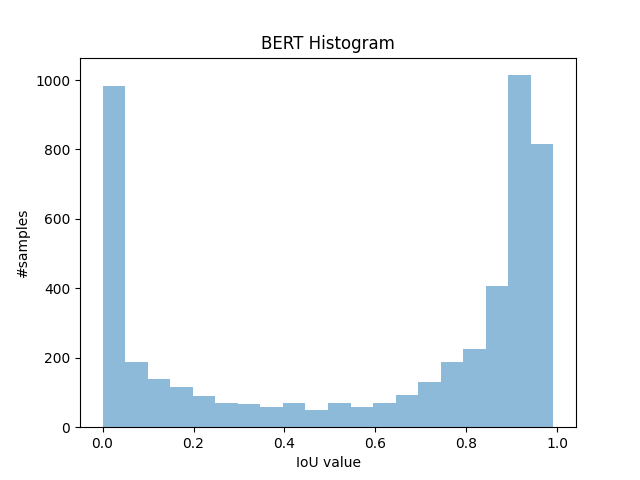

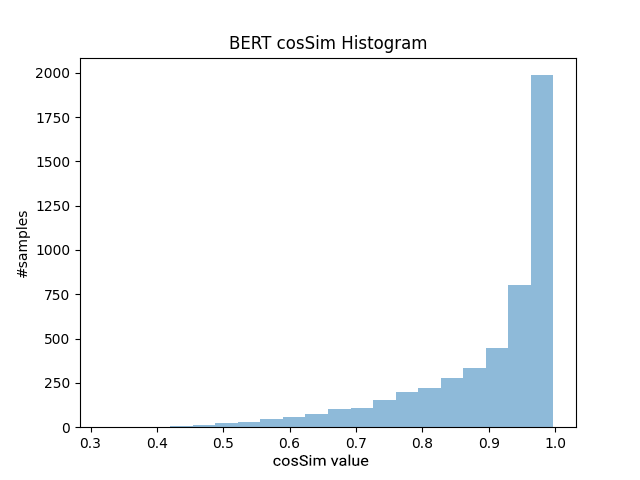

The NLP classifier model exhibits similar distributions of values for two metrics.

### 3. YOLO + NLP + BLIP variation

To streamline the code and focus on the most effective solution, we decided to showcase only the results obtained by the variation. Through our tests, we found that this variation outperformed the YOLO + BLIP model.
This approach allowed us to maintain a more concise and efficient notebook.

In [ ]:
# # model download
blip_model, blip_image_preprocess, blip_text_preprocess = lavis.models.load_model_and_preprocess(
  "blip_image_text_matching", "large", is_eval=True, device=device
)

blip_encoder, _, _ = lavis.models.load_model_and_preprocess(name="blip_feature_extractor",
                                                            model_type="base",
                                                            is_eval=True,
                                                            device=device
                                                            )


blip = [blip_model, blip_image_preprocess, blip_text_preprocess, blip_encoder]

100%|██████████| 3.43G/3.43G [01:00<00:00, 61.1MB/s]
100%|██████████| 1.97G/1.97G [00:56<00:00, 37.6MB/s]


In [ ]:
yoloNlp = BERT_YOLO(device, yolo_model, yolo_param )
YoloBlip = YOLOBlipModel(device, blip, yoloNlp)
evaluate(YoloBlip, dataloader)

mkdir: cannot create directory ‘/content/BERT’: File exists


Downloading...
From: https://drive.google.com/uc?id=104wBJrj67SIZAz89GWoTsKMu-y8fq9tQ&export=download
To: /content/BERT/model.pth
100%|██████████| 438M/438M [00:01<00:00, 227MB/s]


Element to evaluate: 4896


100%|██████████| 4896/4896 [56:08<00:00,  1.45it/s]


--------------------------METRICS--------------------------

Recall: 0.6139705882352942; Mean IoU: 0.5786961563999166; Mean Cosine Similarity: 0.4891979626708609; Mean Euclidean Distance: 223.54857955103606


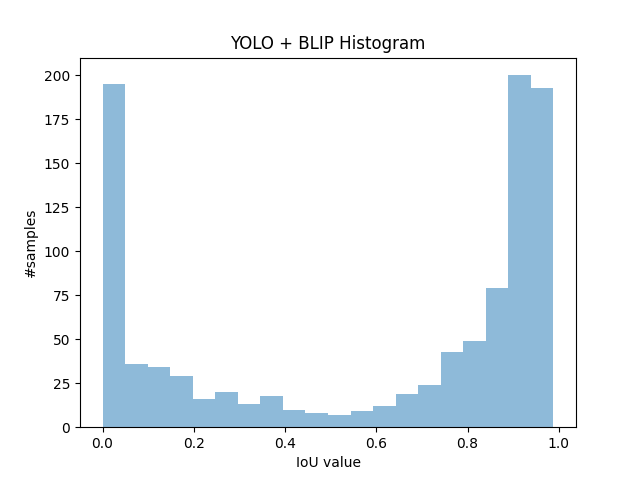

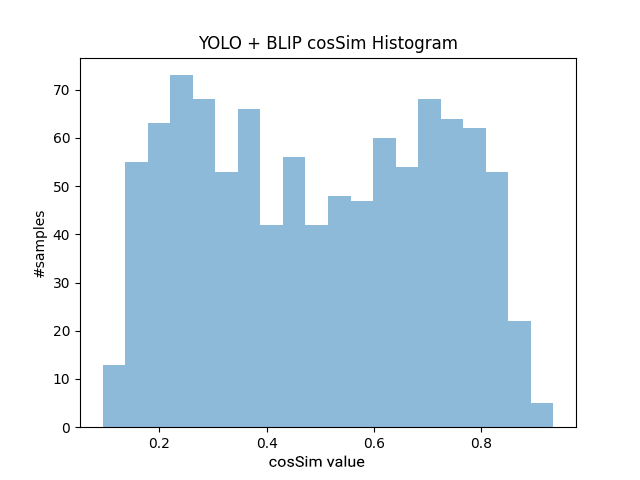

Regarding the cosine similarity values, it is spreaded along the all range

Similar to the baseline the iou distribution tend to vary widely, ranging from near zero to near one

### 4. DETR + CLIP

In [ ]:
detr = DetrClip(device, clip_model)
evaluate(detr, dataloader)

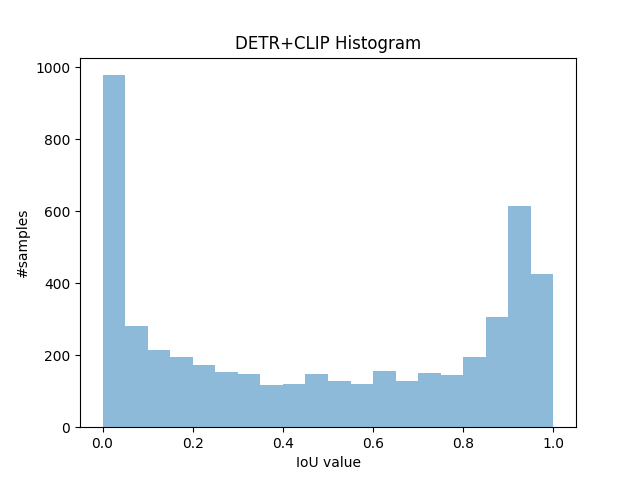

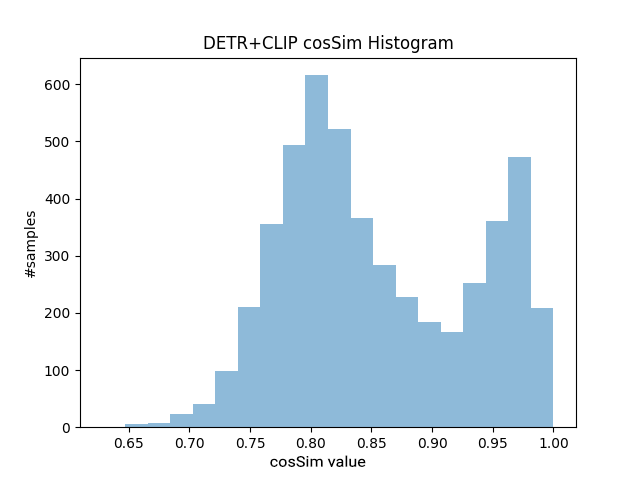

In the case of cosine similarity values, all the values obtained are above of 0.5.

Similarly to the baseline, the distribution of intersection over union (IOU) values tends to have a wide range, spanning from almost zero to nearly one.

## CONCLUSIONS, RESULTS AND DISCUSSION




| Model               | Mean IoU | Mean CosSim | Mean Euclidean Dist | Recall |
|---------------------|----------|-------------|---------------------|--------|
| Baseline + NLP      | 0.5833   | 0.8963      | 0.7788              | 0.62   |
| YOLO + BLIP         | 0.5786   | 0.4892      | 223.54              | 0.61   |
| Baseline            | 0.5262   | 0.8731      | 0.8639              | 0.55   |
| DETR + CLIP         | 0.4768   | 0.8553      | 102.90              | 0.48   |


#### MEAN IoU:
Here we can see the different models we used with the corresponding mean IoU value. This value gives us an idea on the overall performances of the method. For more details we will use different plots. We can see how the performances BERT+CLIP are comparable to the model YOLO + BLIP we tested. With this metric the method DETR + CLIP is performing worse than the baseline.


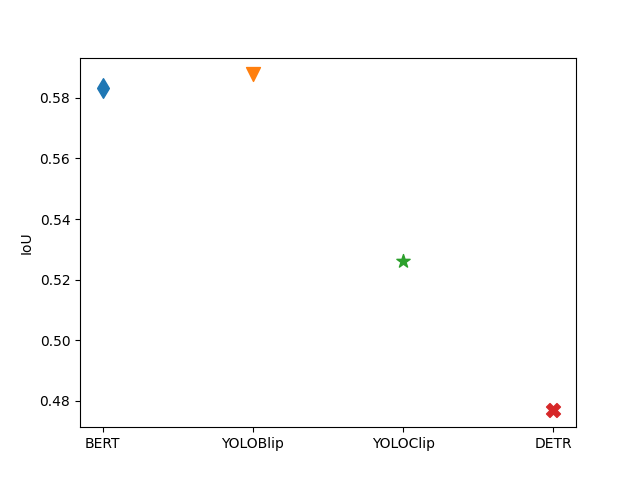

#### Iou above 0.5, 0.7, 0.9:
This plot provides a comprehensive view of performance by counting the number of samples with intersection over union (IoU) values exceeding increasing thresholds. The results show that there is no significant difference in performance compared to previous evaluations, indicating that the algorithms are performing similarly. However, it is interesting to observe the variations in the gaps between the three values for each method. The variations in the gaps between the three values for each method and the placement of the 0.7 threshold relative to the distances between the 0.5 and 0.9 thresholds provide valuable insights to consider.

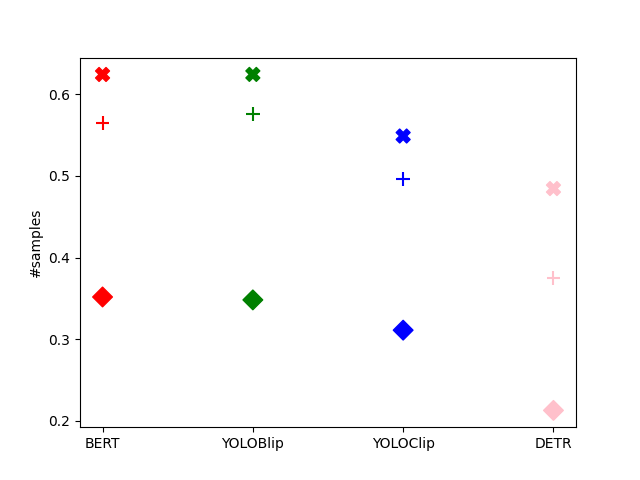

#### Mean euclidian distance:
Euclidean distance is a straight-line measure that quantifies the shortest distance between two points in Euclidean space. If the Euclidean distance is low, it indicates that the model performs well.

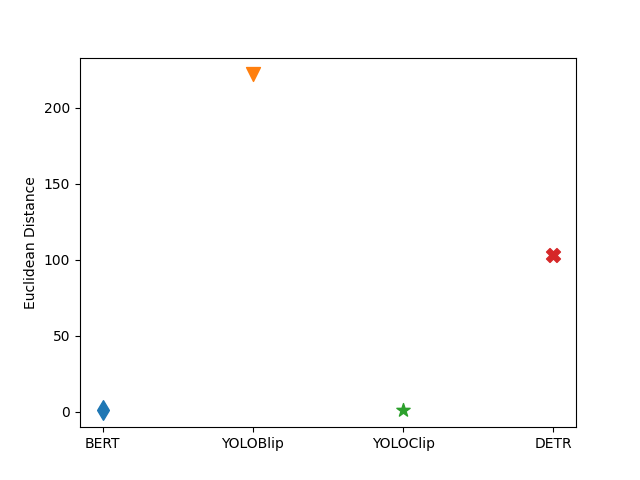

#### Mean cosine similarity:
Cosine similarity is a measure of similarity between two non-zero vectors, which calculates the cosine of the angle between them. It is commonly used to determine the similarity or relatedness of documents or vectors in a high-dimensional space. Maximizing the cosine similarity is desirable because it indicates a higher degree of similarity between two vectors, implying that they align more closely.



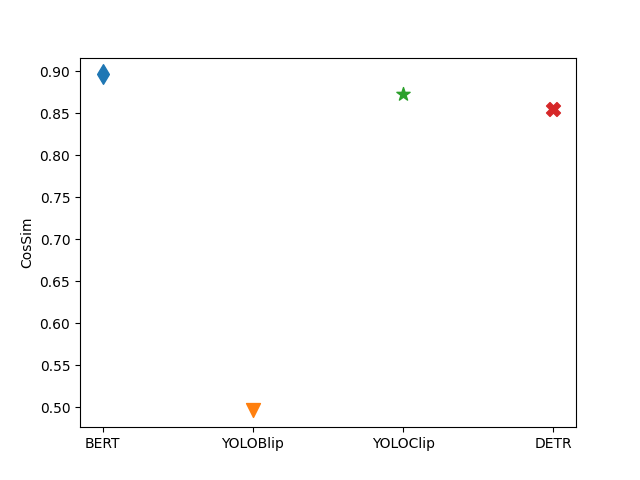

We could see how different models worked and we could extract some information from the above graphs. In the analysis of the models, we need to consider how some of the models are composed. For example the Baseline accuracy should be divided into CLIP and YOLO accuracies. This is because as we can see the cosine similarity is influenced by CLIP mainly, while the IoU is mainly influenced by YOLO performances. Looking at the two metrics in some cases we could find the bottleneck of the system, for example in a case where the IoU is really high but the cosine similarity really low, CLIP might be the problem. YOLO in some cases is not able to extract the bounding boxes that contains the ground truth, and in this cases CLIP can’t do anything to fix the problem. So we should keep a balance between those two metrics.

Another Balance we should keep is in the histogram. This gives us information about the main cause of false negatives and true positives. And if it us balanced or all the samples are in the two extremes of the range.

Looking at the Cosine Similarity Histogram we can see that they are much different one from the other. The IoU histogram is more similar in all the methods. In DETR model the values are more spread trough the range, while in other methods almost all the values are near to 0 and 1.


## FINAL remarks
In this project, we explored different solutions and compared them using various metrics.
We found that the model utilizing the NLP classifier for subject extraction performed the best in terms of accuracy and precision.


## BIBLIOGRAPHY


1. Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., Sastry, G., Askell, A., Mishkin, P., Clark, J., Krueger, G., & Sutskever, I. (2021). Learning Transferable Visual Models From Natural Language Supervision. [arXiv preprint arXiv:2103.00020](https://arxiv.org/abs/2103.00020).
2. Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2021). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. [arXiv preprint arXiv:2010.11929](https://arxiv.org/abs/2010.11929).
3. Carion, N., Massa, F., Synnaeve, G., Usunier, N., Kirillov, A.& Zagoruyko, S. (2020). End-to-End Object Detection with Transformers. [arXiv preprint arXiv:2005.12872](https://arxiv.org/abs/2005.12872).
4. Yang L.& Hu W. (2022). Improving Visual Grounding With Visual-Linguistic Verification and Iterative Reasoning. [Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 9499-9508](https://openaccess.thecvf.com/content/CVPR2022/papers/Yang_Improving_Visual_Grounding_With_Visual-Linguistic_Verification_and_Iterative_Reasoning_CVPR_2022_paper.pdf).
5. Lin T.-Y.& Dollár P.(2014). Microsoft COCO: Common Objects in Context. [arXiv preprint arXiv:1405.0312](https://arxiv.org/abs/1405.0312).
6. Devlin J.& Lee K.(2018). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. [arXiv preprint arXiv:1810.04805](https://arxiv.org/abs/1810.04805).
7. Vaswani A.& Shazeer N.(2017). Attention Is All You Need. [arXiv preprint arXiv:1706.03762](https://arxiv.org/abs/1706.03762).
8. Dosovitskiy A.& Beyer L.(2021). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. [arXiv preprint arXiv:2010.11929](https://arxiv.org/abs/2010.11929).
9. He K.& Zhang X.(2015). Deep Residual Learning for Image Recognition. [arXiv preprint arXiv:1506.02640](https://arxiv.org/abs/1506.02640).
10. Liu W.& Li B.(2021). BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation.[arXiv preprint arXiv:2101.10804](https://arxiv.org/abs/2101.10804).
11. Salesforce Research (n.d.). BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation [Source code]. GitHub.
12. Ramesh A.& Goh G.(2021). Zero-Shot Text-to-Image Generation.[arXiv preprint arXiv:2107.00135](https://arxiv.org/abs/2107.00135).
13. Johnson J.& Karpathy A.(2016). DenseCap: Fully Convolutional Localization Networks for Dense Captioning.[arXiv preprint arXiv:1610.02391](https://arxiv.org/abs/1610.02391).
